In [3]:
import torch
import torch.nn as nn

from torch.utils.data import DataLoader
from torch.utils.data import Dataset

from src.dset import DatasetPhysNetED
from src.archs import PhysNetED

import numpy as np
import configparser
import os
import json
import cv2
import matplotlib.pyplot as plt
from skimage import data, io, filters
from tqdm import tqdm

def train_loop(trainloader, model, loss_fn, optimizer):
    model.train()
    size = len(trainloader.dataset)
    train_preds = np.empty(0)
    train_targets = np.empty(0)

    for batch, (inputs, targets) in enumerate(trainloader):
        inputs = inputs.to(device)
        targets = targets.to(device).squeeze()
        pred = model(inputs).squeeze()

        for cnt, pr in enumerate(pred):
            if (batch_size*batch+cnt)%(int(1/overlap)) == 0:
                p = pr.cpu().detach().numpy().squeeze().flatten()
                t = targets[cnt].cpu().detach().numpy().squeeze().flatten()
                train_preds = np.concatenate((train_preds,p))
                train_targets = np.concatenate((train_targets,t))
                
        loss = loss_fn(pred, targets)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 1 == 0:
            loss, current = loss.item(), batch * len(targets)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
    return train_preds, train_targets
    
def test_loop(testloader, model, loss_fn):
    size = len(testloader.dataset)
    model.eval()    
    test_loss, correct = 0, 0
    test_preds = np.empty(0)
    test_targets = np.empty(0)

    with torch.no_grad():
        for inputs, targets in testloader:
            inputs = inputs.to(device)
            pred = model(inputs).squeeze()
            
            p = pred.cpu().detach().numpy().squeeze().flatten()
            t = targets.cpu().detach().numpy().squeeze().flatten()
            test_preds = np.concatenate((test_preds,p))
            test_targets = np.concatenate((test_targets,t))
        
    return test_preds, test_targets

# if __name__ == '__main__':

configFilename = './config/PURE_PhysNet.cfg'

parser = configparser.ConfigParser(inline_comment_prefixes=('#', ';'))
parser.optionxform = str
parser.read(configFilename)

cfgdict = dict(parser['DEFAULT'].items())
vdir, sigdir = cfgdict['videodataDIR'], cfgdict['signalpath']
print(vdir, sigdir, cfgdict)

# overlap = int(cfgdict['overlap'])
# batch_size = int(cfgdict['batch_size'])
overlap = 0.75
batch_size = 32

print(f'overlap: {overlap}')
print(f'batch_size: {batch_size}')

trainset = DatasetPhysNetED(cfgdict, start = 0, end = 1600, overlap = overlap)
testset = DatasetPhysNetED(cfgdict, start = 1601, end = 2009, overlap = 0)

# Construct DataLoaders
trainloader = DataLoader(trainset,
                        batch_size = batch_size)
testloader = DataLoader(testset,
                        batch_size = batch_size)

# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

# Load Model
model = PhysNetED()
if device != 'cpu':
    model = model.cuda()
loss_fn = nn.MSELoss()
learning_rate = float(cfgdict['learning_rate'])
optimizer =  torch.optim.AdamW(model.parameters(), lr=learning_rate)


# from torch.utils.tensorboard import SummaryWriter
# writer = SummaryWriter('logs/fashion_mnist_experiment_1')

model_name = 'PhysNet_v7'

if not os.path.exists('checkpoints'):
    os.mkdir('checkpoints')
if not os.path.exists('checkpoints/'+model_name):
    os.mkdir('checkpoints/'+model_name)


epochs = 100
train_losses = []
test_losses = []


/home/sim/Dataset/rPPG/PURE/01-01/01-01 /home/sim/Dataset/rPPG/PURE/01-01/01-01.json {'dataset': 'PURE', 'model': 'PhysNet', 'videodataDIR': '/home/sim/Dataset/rPPG/PURE/01-01/01-01', 'signalpath': '/home/sim/Dataset/rPPG/PURE/01-01/01-01.json', 'learning_rate': '1e-3', 'depth': '32', 'height': '128', 'width': '128', 'crop': 'True', 'overlap': '0.75', 'batch_size': '32'}
overlap: 0.75
batch_size: 32
Using cpu device


/home/sim/anaconda3/envs/rppgtorch/lib/python3.7/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at  /opt/conda/conda-bld/pytorch_1616554800319/work/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


## Training code

```python
for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")

    train_preds, train_targets = train_loop(trainloader, model, loss_fn, optimizer)
    test_preds, test_targets = test_loop(testloader, model, loss_fn)

    torch.save(model.state_dict(), 'checkpoints/'+model_name +f'/model_ep{epoch}.pth')

    train_loss = loss_fn(torch.Tensor(train_preds), torch.Tensor(train_targets))
    train_loss = train_loss.cpu().detach().numpy().squeeze()

    test_loss = loss_fn(torch.Tensor(test_preds), torch.Tensor(test_targets))
    test_loss = test_loss.cpu().detach().numpy().squeeze()
    print(f"Test loss: {test_loss:>8f} \n")

    train_losses.append(train_loss)
    test_losses.append(test_loss)

    np.save(model_name+'_loss',(train_preds, train_targets, test_preds, test_targets))

    plt.figure(figsize=[16,4])
    plt.subplot(131)
    plt.plot(train_losses)
    plt.plot(test_losses)

    plt.subplot(132)
    plt.plot(train_preds[:400])
    plt.plot(train_targets[:400])

    plt.subplot(133)
    plt.plot(test_preds)
    plt.plot(test_targets)
    plt.show()
print("Done!")
```


Epoch 1
-------------------------------
loss: 0.776852  [    0/  197]
loss: 0.710385  [   32/  197]
loss: 0.623857  [   64/  197]
loss: 0.660815  [   96/  197]
loss: 0.721073  [  128/  197]
loss: 1.106691  [  160/  197]
loss: 1.761288  [   30/  197]
Test loss: 0.732025 



/home/sim/anaconda3/envs/rppgtorch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



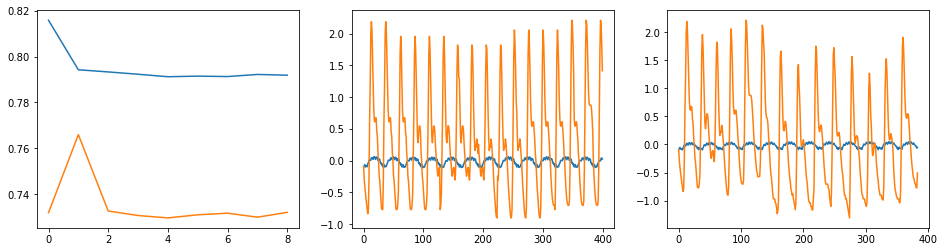

Epoch 2
-------------------------------
loss: 0.771218  [    0/  197]
loss: 0.708663  [   32/  197]
loss: 0.624057  [   64/  197]
loss: 0.660698  [   96/  197]
loss: 0.721448  [  128/  197]
loss: 1.104018  [  160/  197]
loss: 1.707267  [   30/  197]
Test loss: 0.770139 



/home/sim/anaconda3/envs/rppgtorch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



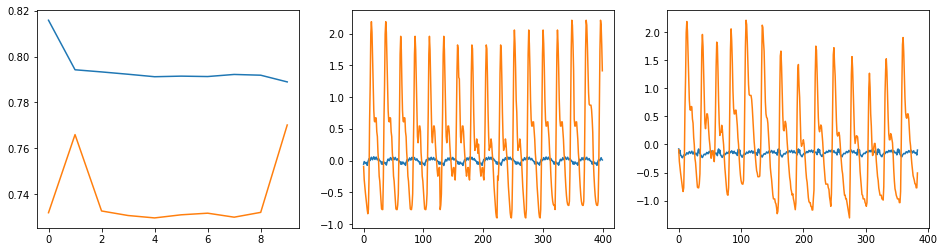

Epoch 3
-------------------------------
loss: 0.775883  [    0/  197]
loss: 0.711139  [   32/  197]
loss: 0.627785  [   64/  197]
loss: 0.659624  [   96/  197]
loss: 0.720491  [  128/  197]
loss: 1.086298  [  160/  197]
loss: 1.615170  [   30/  197]
Test loss: 1.023477 



/home/sim/anaconda3/envs/rppgtorch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



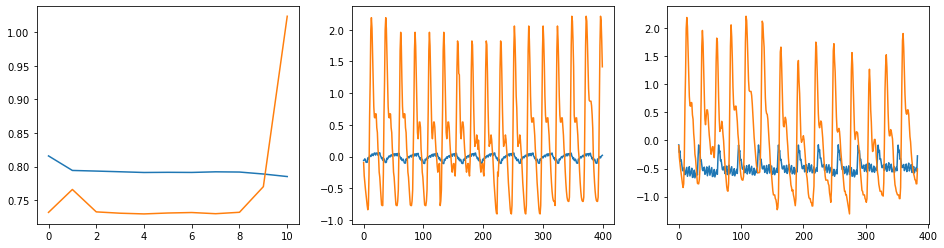

Epoch 4
-------------------------------
loss: 0.776243  [    0/  197]
loss: 0.714745  [   32/  197]
loss: 0.616635  [   64/  197]
loss: 0.745751  [   96/  197]
loss: 0.727334  [  128/  197]
loss: 1.096912  [  160/  197]
loss: 1.862019  [   30/  197]
Test loss: 1.447424 



/home/sim/anaconda3/envs/rppgtorch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



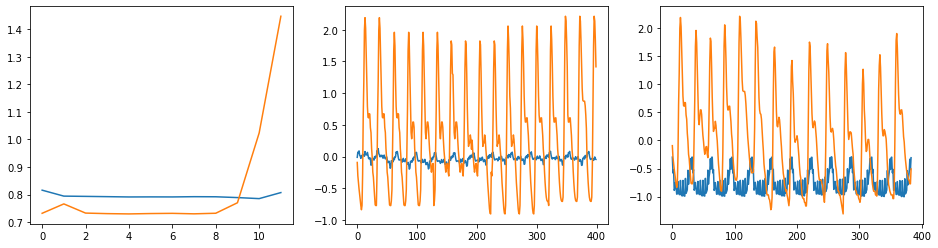

Epoch 5
-------------------------------
loss: 0.782544  [    0/  197]
loss: 0.714180  [   32/  197]
loss: 0.630065  [   64/  197]
loss: 0.671695  [   96/  197]
loss: 0.727724  [  128/  197]
loss: 1.106762  [  160/  197]
loss: 1.758582  [   30/  197]
Test loss: 0.816059 



/home/sim/anaconda3/envs/rppgtorch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



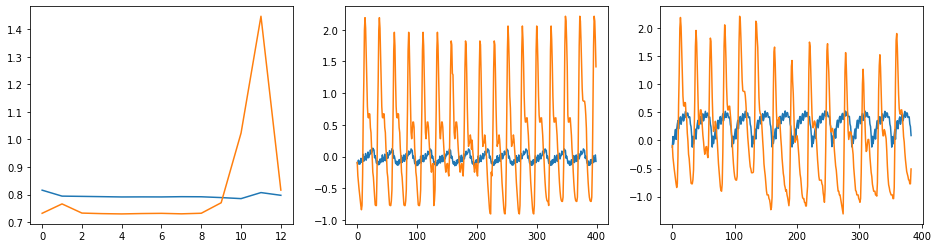

Epoch 6
-------------------------------
loss: 0.780437  [    0/  197]
loss: 0.712142  [   32/  197]
loss: 0.622693  [   64/  197]
loss: 0.667150  [   96/  197]
loss: 0.724809  [  128/  197]
loss: 1.101757  [  160/  197]
loss: 1.777184  [   30/  197]
Test loss: 0.799899 



/home/sim/anaconda3/envs/rppgtorch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



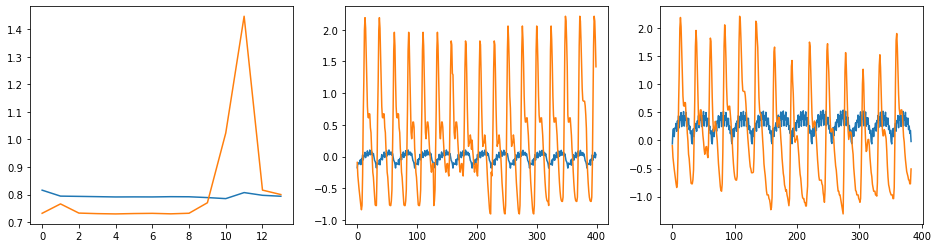

Epoch 7
-------------------------------
loss: 0.775958  [    0/  197]
loss: 0.710908  [   32/  197]
loss: 0.621227  [   64/  197]
loss: 0.664803  [   96/  197]
loss: 0.723660  [  128/  197]
loss: 1.099300  [  160/  197]
loss: 1.774543  [   30/  197]
Test loss: 0.730462 



/home/sim/anaconda3/envs/rppgtorch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



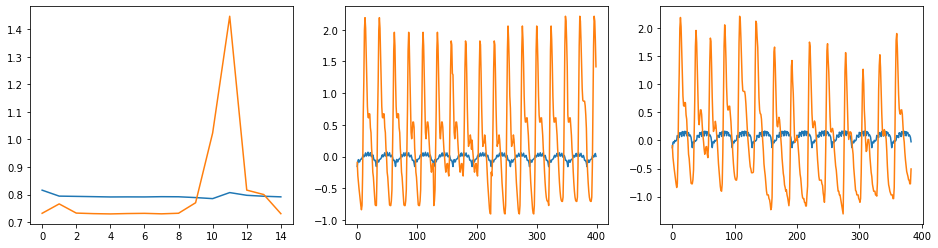

Epoch 8
-------------------------------
loss: 0.776074  [    0/  197]
loss: 0.709875  [   32/  197]
loss: 0.620844  [   64/  197]
loss: 0.664038  [   96/  197]
loss: 0.723539  [  128/  197]
loss: 1.098611  [  160/  197]
loss: 1.755977  [   30/  197]
Test loss: 0.729018 



/home/sim/anaconda3/envs/rppgtorch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



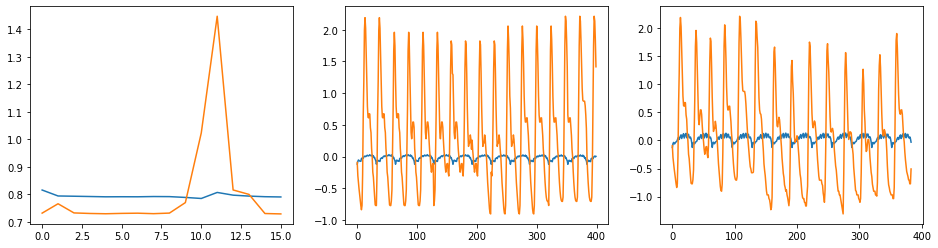

Epoch 9
-------------------------------
loss: 0.776773  [    0/  197]
loss: 0.710249  [   32/  197]
loss: 0.621039  [   64/  197]
loss: 0.665064  [   96/  197]
loss: 0.724141  [  128/  197]
loss: 1.098574  [  160/  197]
loss: 1.761485  [   30/  197]
Test loss: 0.729651 



/home/sim/anaconda3/envs/rppgtorch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



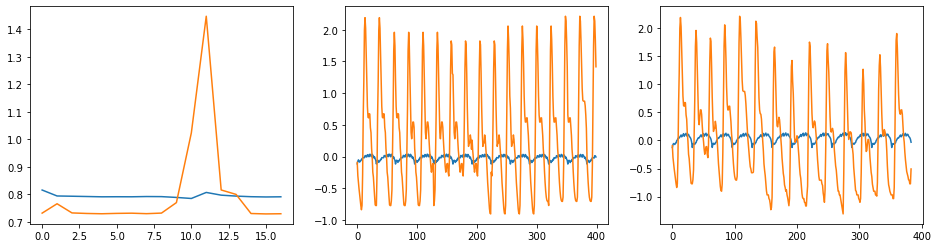

Epoch 10
-------------------------------
loss: 0.778509  [    0/  197]
loss: 0.711372  [   32/  197]
loss: 0.621714  [   64/  197]
loss: 0.666640  [   96/  197]
loss: 0.724694  [  128/  197]
loss: 1.099303  [  160/  197]
loss: 1.741804  [   30/  197]
Test loss: 0.731351 



/home/sim/anaconda3/envs/rppgtorch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



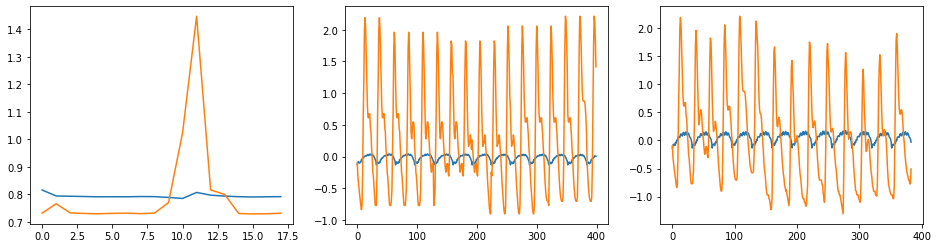

Epoch 11
-------------------------------
loss: 0.779451  [    0/  197]
loss: 0.712509  [   32/  197]
loss: 0.622429  [   64/  197]
loss: 0.667081  [   96/  197]
loss: 0.724457  [  128/  197]
loss: 1.100138  [  160/  197]
loss: 1.761922  [   30/  197]
Test loss: 0.731587 



/home/sim/anaconda3/envs/rppgtorch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



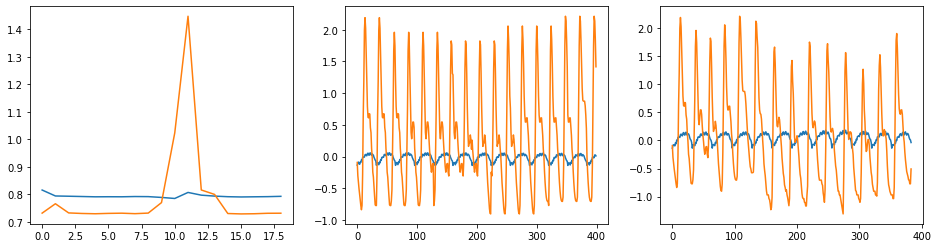

Epoch 12
-------------------------------
loss: 0.779119  [    0/  197]
loss: 0.712964  [   32/  197]
loss: 0.622151  [   64/  197]
loss: 0.665002  [   96/  197]
loss: 0.722674  [  128/  197]
loss: 1.098767  [  160/  197]
loss: 1.740509  [   30/  197]
Test loss: 0.731164 



/home/sim/anaconda3/envs/rppgtorch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



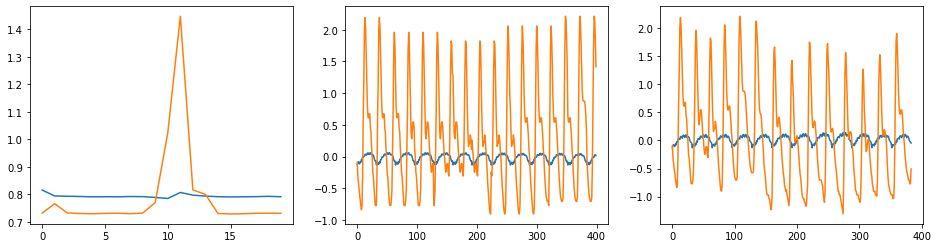

Epoch 13
-------------------------------
loss: 0.777411  [    0/  197]
loss: 0.713268  [   32/  197]
loss: 0.622193  [   64/  197]
loss: 0.662071  [   96/  197]
loss: 0.720624  [  128/  197]
loss: 1.097510  [  160/  197]
loss: 1.675705  [   30/  197]
Test loss: 0.742771 



/home/sim/anaconda3/envs/rppgtorch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



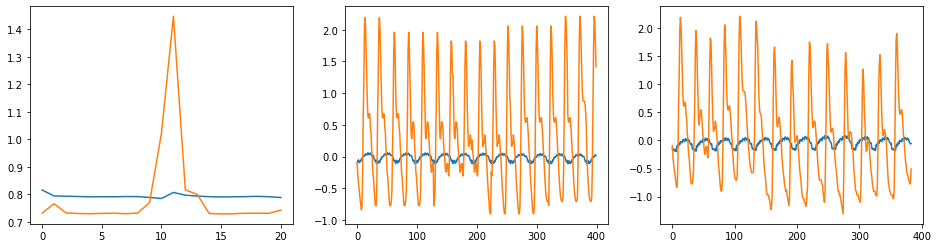

Epoch 14
-------------------------------
loss: 0.780001  [    0/  197]
loss: 0.715595  [   32/  197]
loss: 0.626494  [   64/  197]
loss: 0.663518  [   96/  197]
loss: 0.722577  [  128/  197]
loss: 1.094632  [  160/  197]
loss: 1.717223  [   30/  197]
Test loss: 0.738857 



/home/sim/anaconda3/envs/rppgtorch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



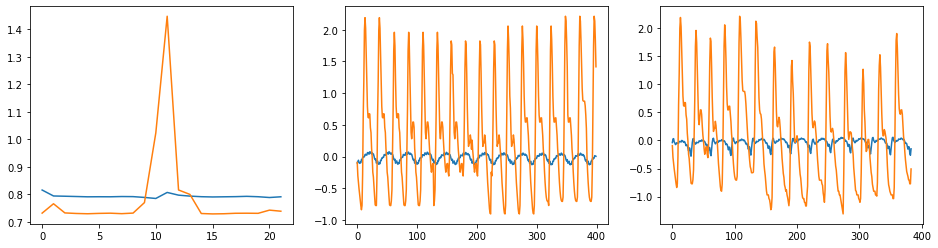

Epoch 15
-------------------------------
loss: 0.780946  [    0/  197]
loss: 0.722311  [   32/  197]
loss: 0.632061  [   64/  197]
loss: 0.656026  [   96/  197]
loss: 0.719124  [  128/  197]
loss: 1.086655  [  160/  197]
loss: 1.555948  [   30/  197]
Test loss: 0.733167 



/home/sim/anaconda3/envs/rppgtorch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



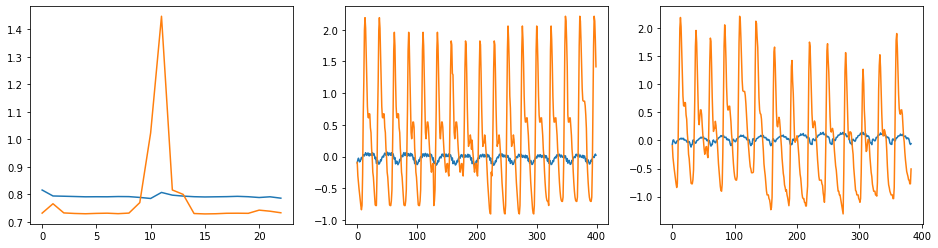

Epoch 16
-------------------------------
loss: 0.772299  [    0/  197]
loss: 0.714765  [   32/  197]
loss: 0.622485  [   64/  197]
loss: 0.653761  [   96/  197]
loss: 0.717128  [  128/  197]
loss: 1.094498  [  160/  197]
loss: 1.537818  [   30/  197]
Test loss: 0.747505 



/home/sim/anaconda3/envs/rppgtorch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



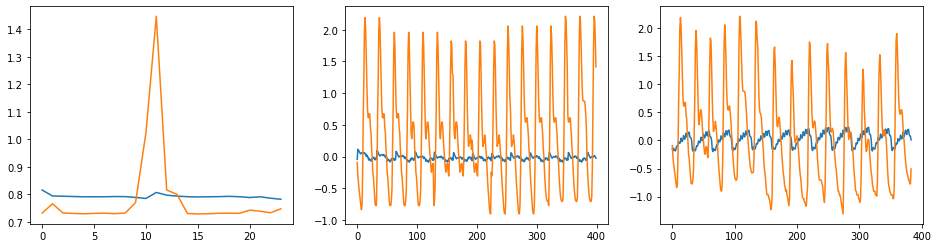

Epoch 17
-------------------------------
loss: 0.776763  [    0/  197]
loss: 0.710627  [   32/  197]
loss: 0.617731  [   64/  197]
loss: 0.659742  [   96/  197]
loss: 0.724169  [  128/  197]
loss: 1.084409  [  160/  197]
loss: 2.034740  [   30/  197]
Test loss: 1.047908 



/home/sim/anaconda3/envs/rppgtorch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



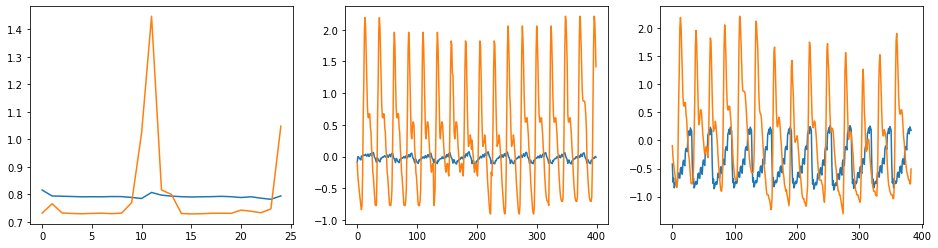

Epoch 18
-------------------------------
loss: 0.780204  [    0/  197]
loss: 0.710331  [   32/  197]
loss: 0.627145  [   64/  197]
loss: 0.660061  [   96/  197]
loss: 0.721367  [  128/  197]
loss: 1.101462  [  160/  197]
loss: 1.782050  [   30/  197]
Test loss: 0.732917 



/home/sim/anaconda3/envs/rppgtorch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



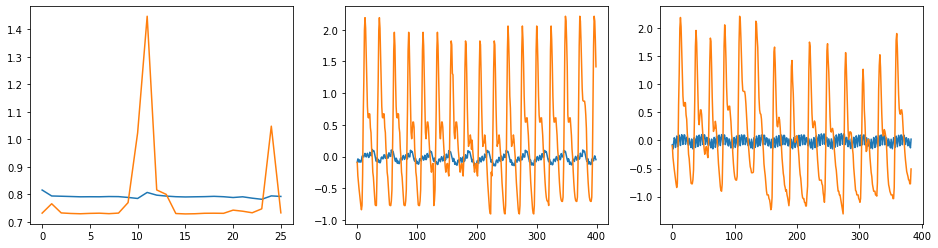

Epoch 19
-------------------------------
loss: 0.774240  [    0/  197]
loss: 0.708926  [   32/  197]
loss: 0.622632  [   64/  197]
loss: 0.661777  [   96/  197]
loss: 0.723746  [  128/  197]
loss: 1.099774  [  160/  197]
loss: 1.915189  [   30/  197]
Test loss: 0.737351 



/home/sim/anaconda3/envs/rppgtorch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



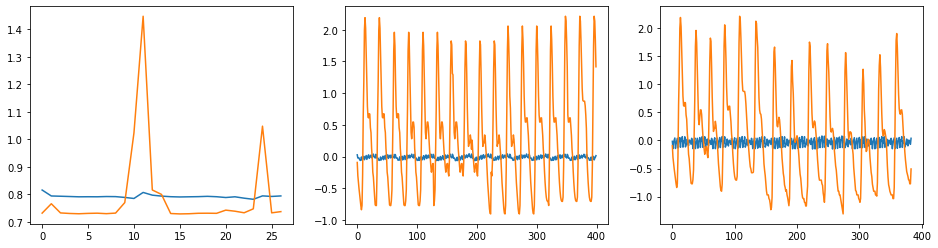

Epoch 20
-------------------------------
loss: 0.773328  [    0/  197]
loss: 0.708704  [   32/  197]
loss: 0.621215  [   64/  197]
loss: 0.660706  [   96/  197]
loss: 0.721916  [  128/  197]
loss: 1.097898  [  160/  197]
loss: 1.709392  [   30/  197]
Test loss: 0.735313 



/home/sim/anaconda3/envs/rppgtorch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



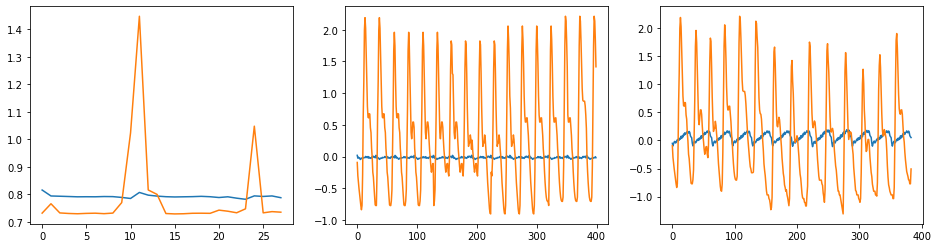

Epoch 21
-------------------------------
loss: 0.775826  [    0/  197]
loss: 0.709439  [   32/  197]
loss: 0.621668  [   64/  197]
loss: 0.663489  [   96/  197]
loss: 0.723014  [  128/  197]
loss: 1.098428  [  160/  197]
loss: 1.566073  [   30/  197]
Test loss: 0.742052 



/home/sim/anaconda3/envs/rppgtorch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



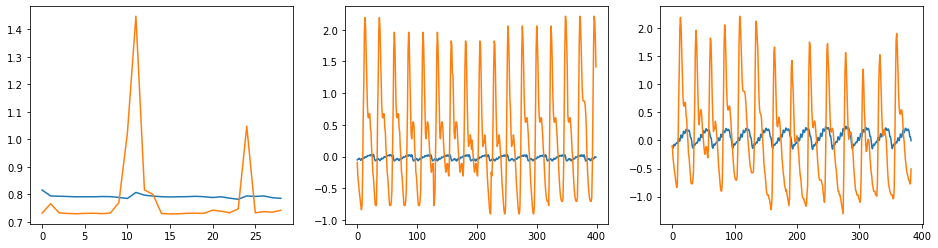

Epoch 22
-------------------------------
loss: 0.781555  [    0/  197]
loss: 0.712698  [   32/  197]
loss: 0.625680  [   64/  197]
loss: 0.667720  [   96/  197]
loss: 0.724571  [  128/  197]
loss: 1.098518  [  160/  197]
loss: 1.501380  [   30/  197]
Test loss: 0.741825 



/home/sim/anaconda3/envs/rppgtorch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



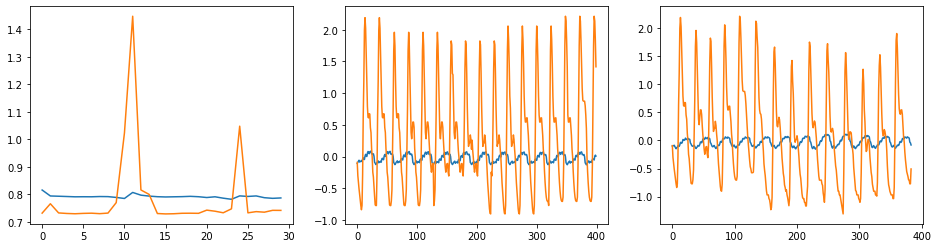

Epoch 23
-------------------------------
loss: 0.778197  [    0/  197]
loss: 0.711226  [   32/  197]
loss: 0.620978  [   64/  197]
loss: 0.657393  [   96/  197]
loss: 0.720232  [  128/  197]
loss: 1.089341  [  160/  197]
loss: 1.822941  [   30/  197]
Test loss: 0.742521 



/home/sim/anaconda3/envs/rppgtorch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



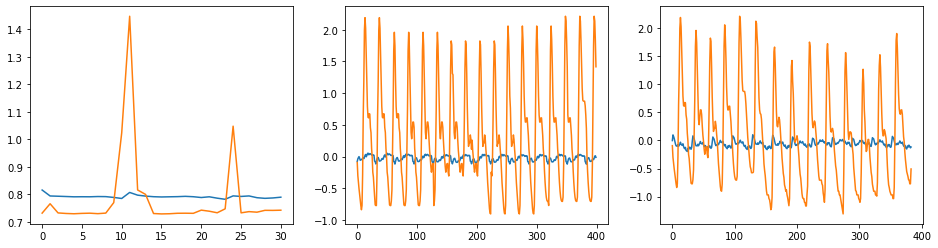

Epoch 24
-------------------------------
loss: 0.773974  [    0/  197]
loss: 0.714330  [   32/  197]
loss: 0.621200  [   64/  197]
loss: 0.658315  [   96/  197]
loss: 0.719147  [  128/  197]
loss: 1.092699  [  160/  197]
loss: 1.498244  [   30/  197]
Test loss: 0.976310 



/home/sim/anaconda3/envs/rppgtorch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



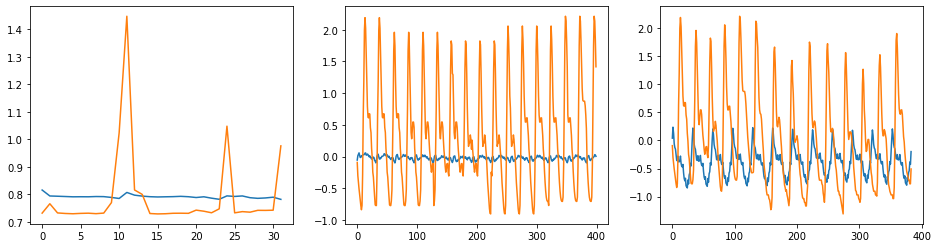

Epoch 25
-------------------------------
loss: 0.774385  [    0/  197]
loss: 0.712077  [   32/  197]
loss: 0.621188  [   64/  197]
loss: 0.652210  [   96/  197]
loss: 0.715811  [  128/  197]
loss: 1.092079  [  160/  197]
loss: 1.553009  [   30/  197]
Test loss: 0.818483 



/home/sim/anaconda3/envs/rppgtorch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



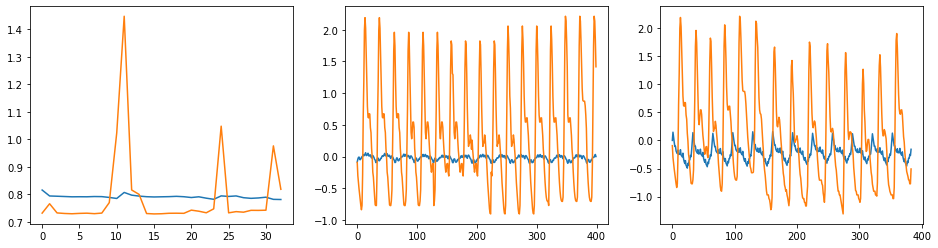

Epoch 26
-------------------------------
loss: 0.771614  [    0/  197]
loss: 0.714284  [   32/  197]
loss: 0.619788  [   64/  197]
loss: 0.649509  [   96/  197]
loss: 0.714083  [  128/  197]
loss: 1.083667  [  160/  197]
loss: 1.455900  [   30/  197]
Test loss: 0.904551 



/home/sim/anaconda3/envs/rppgtorch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



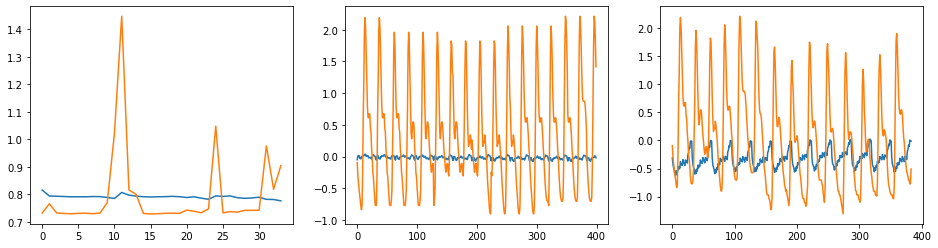

Epoch 27
-------------------------------
loss: 0.771933  [    0/  197]
loss: 0.716885  [   32/  197]
loss: 0.620159  [   64/  197]
loss: 0.645396  [   96/  197]
loss: 0.710126  [  128/  197]
loss: 1.081069  [  160/  197]
loss: 1.759309  [   30/  197]
Test loss: 0.931494 



/home/sim/anaconda3/envs/rppgtorch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



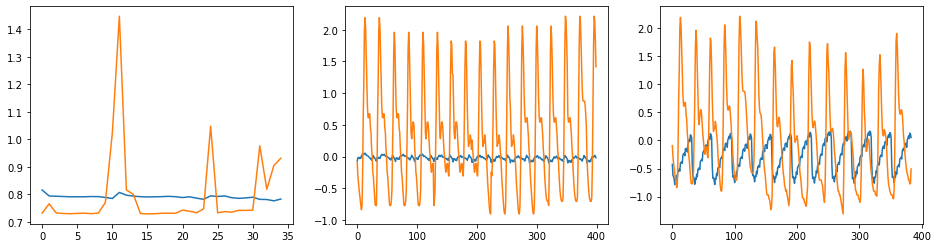

Epoch 28
-------------------------------
loss: 0.766767  [    0/  197]
loss: 0.718525  [   32/  197]
loss: 0.624768  [   64/  197]
loss: 0.642534  [   96/  197]
loss: 0.706705  [  128/  197]
loss: 1.062775  [  160/  197]
loss: 1.772686  [   30/  197]
Test loss: 0.852236 



/home/sim/anaconda3/envs/rppgtorch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



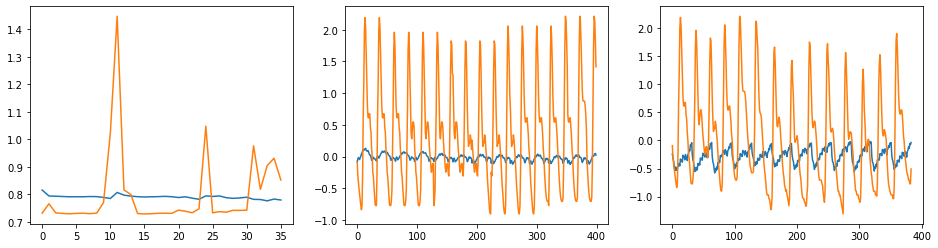

Epoch 29
-------------------------------
loss: 0.767466  [    0/  197]
loss: 0.711419  [   32/  197]
loss: 0.612323  [   64/  197]
loss: 0.641127  [   96/  197]
loss: 0.704213  [  128/  197]
loss: 1.051931  [  160/  197]
loss: 1.504138  [   30/  197]
Test loss: 1.247682 



/home/sim/anaconda3/envs/rppgtorch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



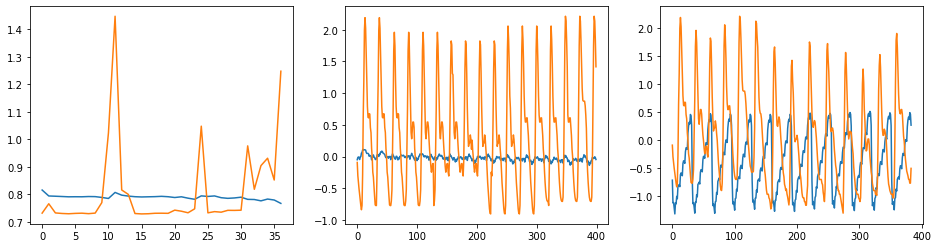

Epoch 30
-------------------------------
loss: 0.757911  [    0/  197]
loss: 0.721800  [   32/  197]
loss: 0.613832  [   64/  197]
loss: 0.645659  [   96/  197]
loss: 0.709428  [  128/  197]
loss: 1.078698  [  160/  197]
loss: 1.546750  [   30/  197]
Test loss: 1.380568 



/home/sim/anaconda3/envs/rppgtorch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



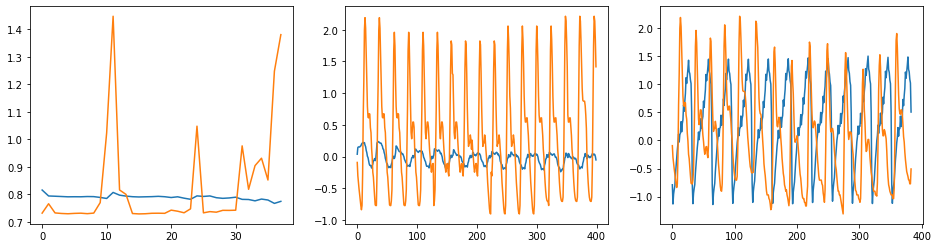

Epoch 31
-------------------------------
loss: 0.762459  [    0/  197]
loss: 0.730002  [   32/  197]
loss: 0.628458  [   64/  197]
loss: 0.630466  [   96/  197]
loss: 0.713572  [  128/  197]
loss: 1.084972  [  160/  197]
loss: 1.507002  [   30/  197]
Test loss: 1.443053 



/home/sim/anaconda3/envs/rppgtorch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



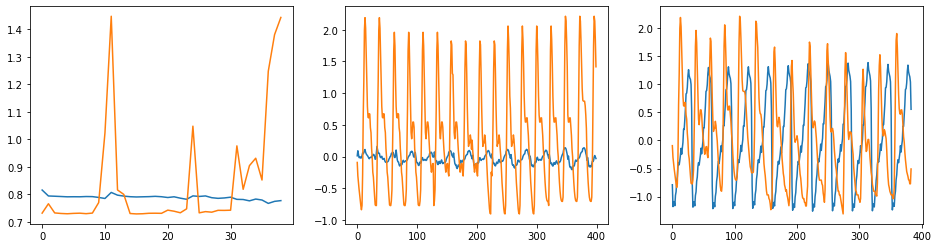

Epoch 32
-------------------------------
loss: 0.750616  [    0/  197]
loss: 0.697420  [   32/  197]
loss: 0.612580  [   64/  197]
loss: 0.638529  [   96/  197]
loss: 0.698399  [  128/  197]
loss: 1.048326  [  160/  197]
loss: 1.545649  [   30/  197]
Test loss: 2.269070 



/home/sim/anaconda3/envs/rppgtorch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



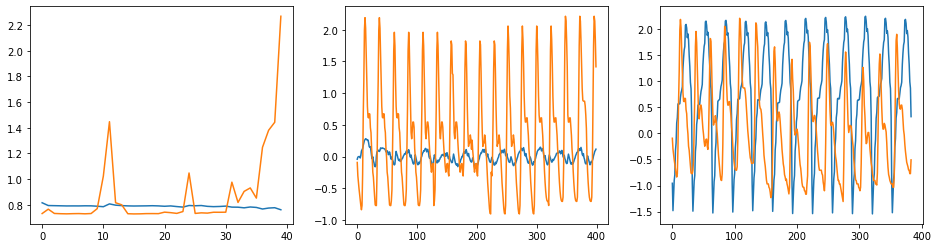

Epoch 33
-------------------------------
loss: 0.742419  [    0/  197]
loss: 0.688977  [   32/  197]
loss: 0.590747  [   64/  197]
loss: 0.599699  [   96/  197]
loss: 0.673221  [  128/  197]
loss: 1.006217  [  160/  197]
loss: 1.541836  [   30/  197]
Test loss: 3.681672 



/home/sim/anaconda3/envs/rppgtorch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



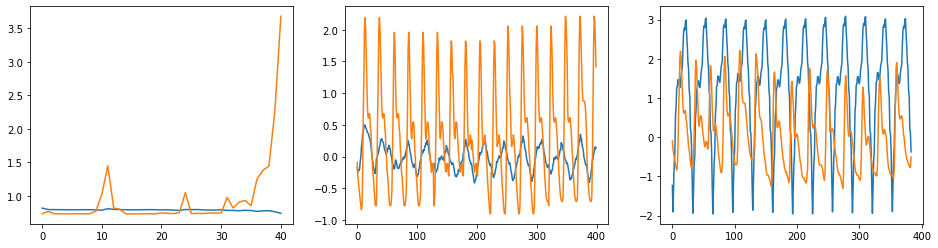

Epoch 34
-------------------------------
loss: 0.828519  [    0/  197]
loss: 0.716120  [   32/  197]
loss: 0.614157  [   64/  197]
loss: 0.590037  [   96/  197]
loss: 0.667384  [  128/  197]
loss: 0.991211  [  160/  197]
loss: 1.505908  [   30/  197]
Test loss: 2.315963 



/home/sim/anaconda3/envs/rppgtorch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



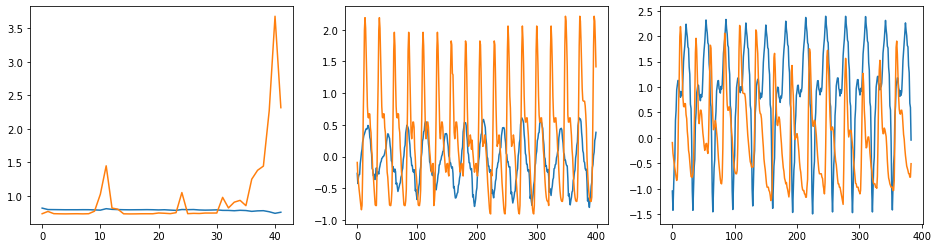

Epoch 35
-------------------------------
loss: 0.678038  [    0/  197]
loss: 0.646470  [   32/  197]
loss: 0.565573  [   64/  197]
loss: 0.558605  [   96/  197]
loss: 0.586234  [  128/  197]
loss: 0.859311  [  160/  197]
loss: 1.666433  [   30/  197]
Test loss: 1.561468 



/home/sim/anaconda3/envs/rppgtorch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



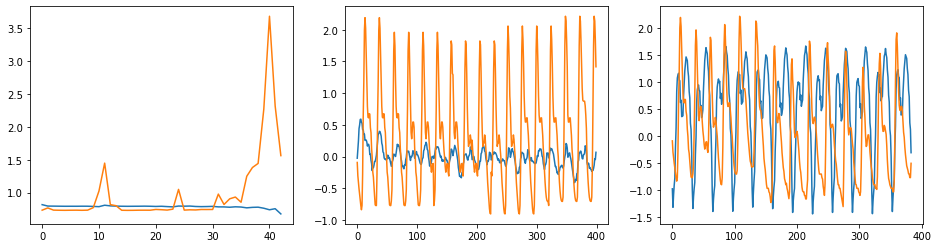

Epoch 36
-------------------------------
loss: 0.851357  [    0/  197]
loss: 0.695522  [   32/  197]
loss: 0.634531  [   64/  197]
loss: 0.632005  [   96/  197]
loss: 0.703559  [  128/  197]
loss: 1.047263  [  160/  197]
loss: 1.596437  [   30/  197]
Test loss: 1.430865 



/home/sim/anaconda3/envs/rppgtorch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



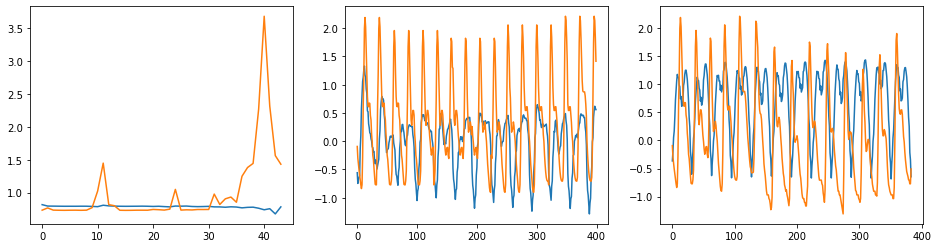

Epoch 37
-------------------------------
loss: 0.733842  [    0/  197]
loss: 0.654568  [   32/  197]
loss: 0.580001  [   64/  197]
loss: 0.565006  [   96/  197]
loss: 0.567418  [  128/  197]
loss: 0.896350  [  160/  197]
loss: 1.507303  [   30/  197]
Test loss: 1.555283 



/home/sim/anaconda3/envs/rppgtorch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



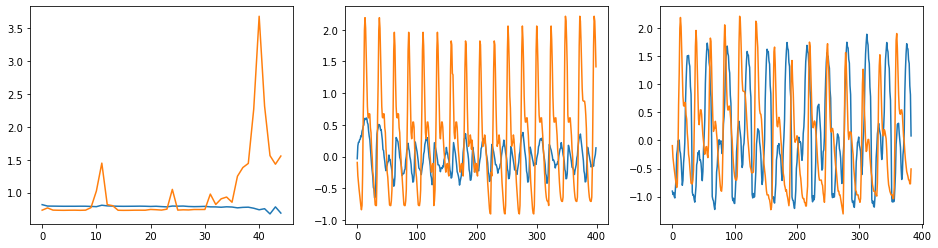

Epoch 38
-------------------------------
loss: 0.598595  [    0/  197]
loss: 0.569420  [   32/  197]
loss: 0.524143  [   64/  197]
loss: 0.509980  [   96/  197]
loss: 0.520723  [  128/  197]
loss: 0.744066  [  160/  197]
loss: 1.465171  [   30/  197]
Test loss: 1.168418 



/home/sim/anaconda3/envs/rppgtorch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



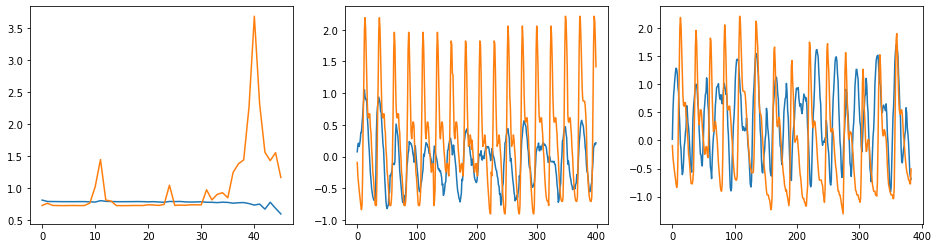

Epoch 39
-------------------------------
loss: 0.490078  [    0/  197]
loss: 0.521914  [   32/  197]
loss: 0.508602  [   64/  197]
loss: 0.558398  [   96/  197]
loss: 0.548280  [  128/  197]
loss: 0.865386  [  160/  197]
loss: 1.490353  [   30/  197]
Test loss: 0.974149 



/home/sim/anaconda3/envs/rppgtorch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



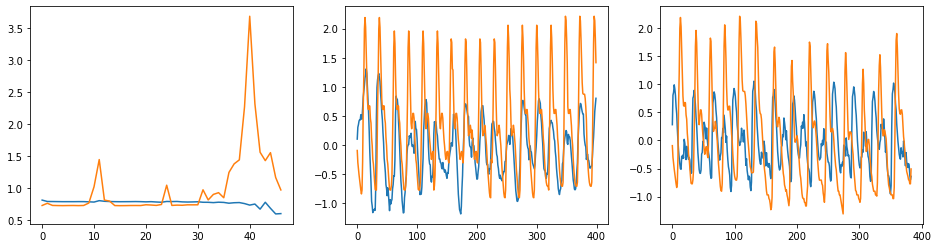

Epoch 40
-------------------------------
loss: 0.590968  [    0/  197]
loss: 0.398695  [   32/  197]
loss: 0.428037  [   64/  197]
loss: 0.428916  [   96/  197]
loss: 0.354655  [  128/  197]
loss: 0.648613  [  160/  197]
loss: 1.292618  [   30/  197]
Test loss: 1.009472 



/home/sim/anaconda3/envs/rppgtorch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



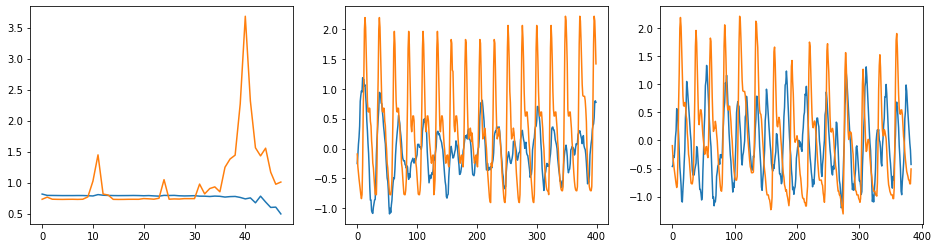

Epoch 41
-------------------------------
loss: 0.574150  [    0/  197]
loss: 0.393359  [   32/  197]
loss: 0.434794  [   64/  197]
loss: 0.464573  [   96/  197]
loss: 0.449753  [  128/  197]
loss: 0.712513  [  160/  197]
loss: 1.302469  [   30/  197]
Test loss: 0.952616 



/home/sim/anaconda3/envs/rppgtorch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



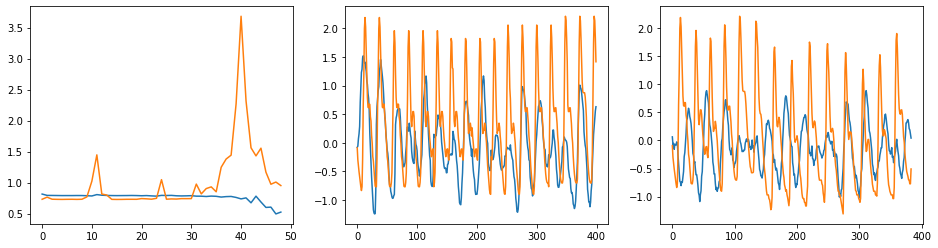

Epoch 42
-------------------------------
loss: 0.516075  [    0/  197]
loss: 0.396460  [   64/  197]
loss: 0.433599  [   96/  197]
loss: 0.486562  [  128/  197]
loss: 0.852768  [  160/  197]
loss: 1.335227  [   30/  197]
Test loss: 1.239677 



/home/sim/anaconda3/envs/rppgtorch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



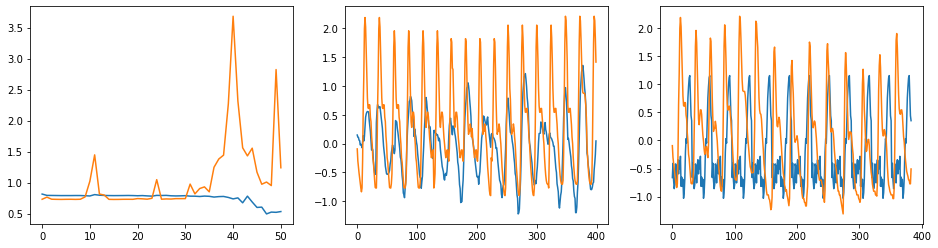

Epoch 44
-------------------------------
loss: 0.485616  [    0/  197]
loss: 0.385855  [   32/  197]
loss: 0.368630  [   64/  197]
loss: 0.353828  [   96/  197]
loss: 0.291812  [  128/  197]
loss: 0.581386  [  160/  197]
loss: 1.827888  [   30/  197]
Test loss: 1.396452 



/home/sim/anaconda3/envs/rppgtorch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



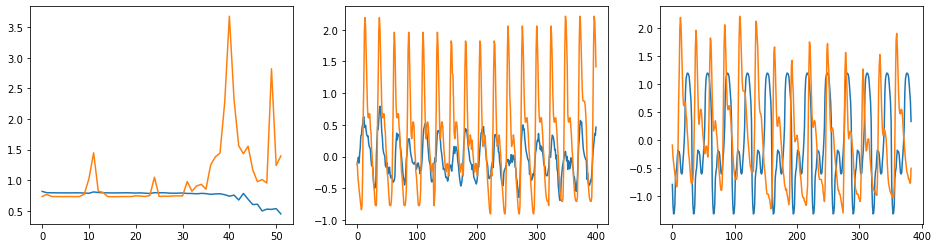

Epoch 45
-------------------------------
loss: 0.374169  [    0/  197]
loss: 0.300579  [   32/  197]
loss: 0.391977  [   64/  197]
loss: 0.309538  [   96/  197]
loss: 0.294925  [  128/  197]
loss: 0.562130  [  160/  197]
loss: 1.075647  [   30/  197]
Test loss: 1.782063 



/home/sim/anaconda3/envs/rppgtorch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



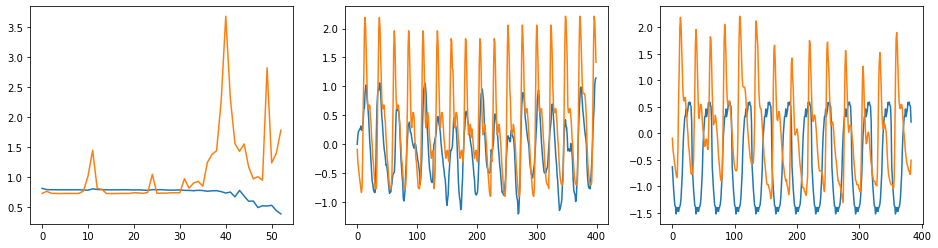

Epoch 46
-------------------------------
loss: 0.416365  [    0/  197]
loss: 0.296850  [   32/  197]
loss: 0.366366  [   64/  197]
loss: 0.372324  [   96/  197]
loss: 0.368848  [  128/  197]
loss: 0.620042  [  160/  197]
loss: 1.403575  [   30/  197]
Test loss: 1.205096 



/home/sim/anaconda3/envs/rppgtorch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



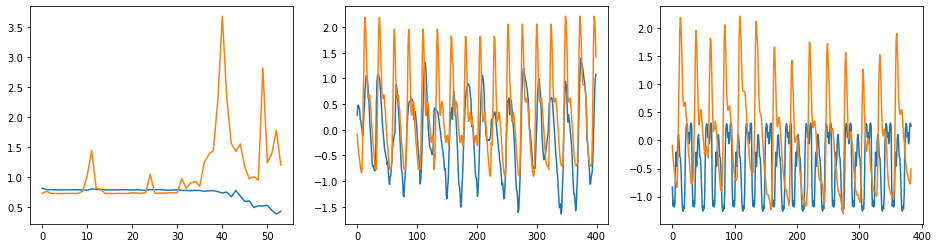

Epoch 47
-------------------------------
loss: 0.419893  [    0/  197]
loss: 0.309661  [   32/  197]
loss: 0.342984  [   64/  197]
loss: 0.391095  [   96/  197]
loss: 0.383835  [  128/  197]
loss: 0.588459  [  160/  197]
loss: 1.022000  [   30/  197]
Test loss: 1.338832 



/home/sim/anaconda3/envs/rppgtorch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



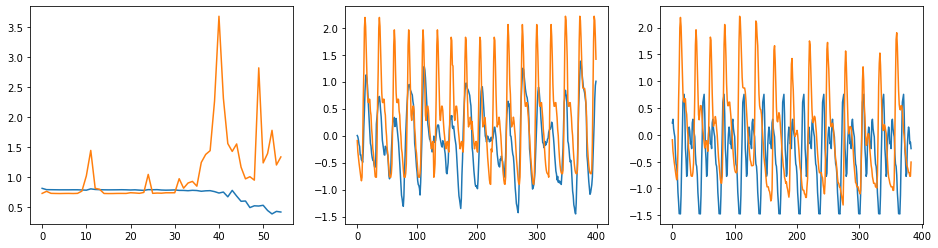

Epoch 48
-------------------------------
loss: 0.486258  [    0/  197]
loss: 0.356298  [   32/  197]
loss: 0.448588  [   64/  197]
loss: 0.388491  [   96/  197]
loss: 0.364237  [  128/  197]
loss: 0.606027  [  160/  197]
loss: 0.915664  [   30/  197]
Test loss: 1.460343 



/home/sim/anaconda3/envs/rppgtorch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



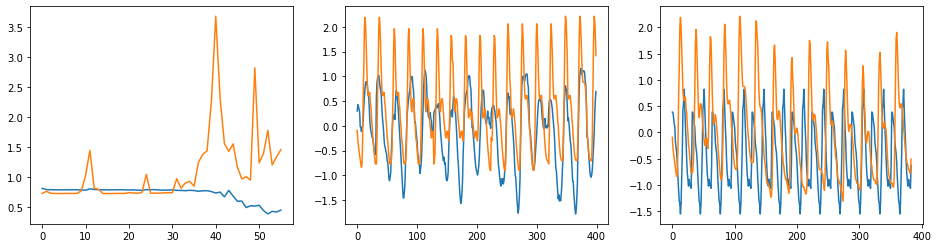

Epoch 49
-------------------------------
loss: 0.562742  [    0/  197]
loss: 0.323222  [   32/  197]
loss: 0.392814  [   64/  197]
loss: 0.328972  [   96/  197]
loss: 0.351209  [  128/  197]
loss: 0.599495  [  160/  197]
loss: 0.914588  [   30/  197]
Test loss: 1.536374 



/home/sim/anaconda3/envs/rppgtorch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



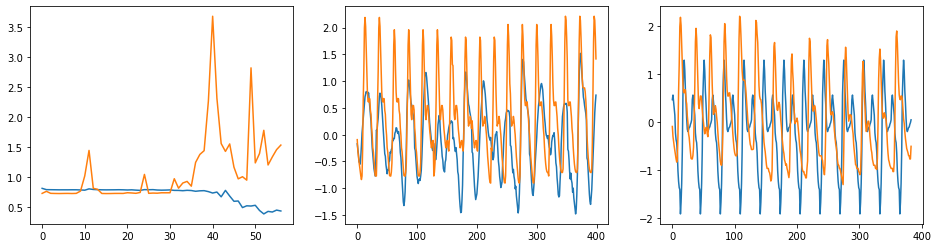

Epoch 50
-------------------------------
loss: 0.337772  [    0/  197]
loss: 0.320597  [   32/  197]
loss: 0.344511  [   64/  197]
loss: 0.311841  [   96/  197]
loss: 0.272524  [  128/  197]
loss: 0.519059  [  160/  197]
loss: 0.640472  [   30/  197]
Test loss: 1.300449 



/home/sim/anaconda3/envs/rppgtorch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



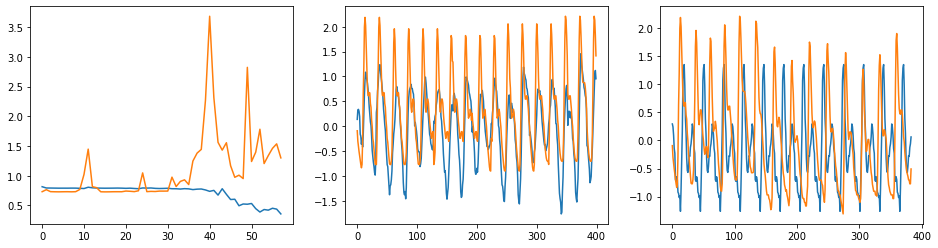

Epoch 51
-------------------------------
loss: 0.303068  [    0/  197]
loss: 0.234723  [   32/  197]
loss: 0.302203  [   64/  197]
loss: 0.270739  [   96/  197]
loss: 0.234485  [  128/  197]
loss: 0.491323  [  160/  197]
loss: 0.630394  [   30/  197]
Test loss: 2.177428 



/home/sim/anaconda3/envs/rppgtorch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



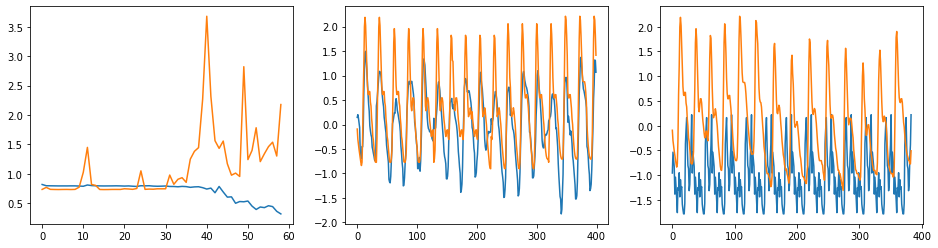

Epoch 52
-------------------------------
loss: 0.372851  [    0/  197]
loss: 0.269588  [   32/  197]
loss: 0.317572  [   64/  197]
loss: 0.261235  [   96/  197]
loss: 0.241575  [  128/  197]
loss: 0.479572  [  160/  197]
loss: 0.581007  [   30/  197]
Test loss: 1.873010 



/home/sim/anaconda3/envs/rppgtorch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



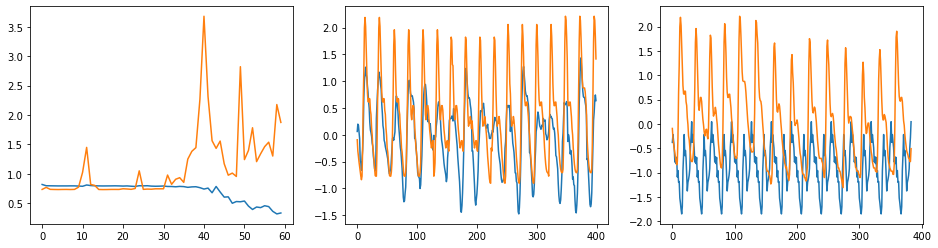

Epoch 53
-------------------------------
loss: 0.282495  [    0/  197]
loss: 0.279342  [   32/  197]
loss: 0.363198  [   64/  197]
loss: 0.243546  [   96/  197]
loss: 0.183354  [  128/  197]
loss: 0.439029  [  160/  197]
loss: 0.572943  [   30/  197]
Test loss: 1.553549 



/home/sim/anaconda3/envs/rppgtorch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



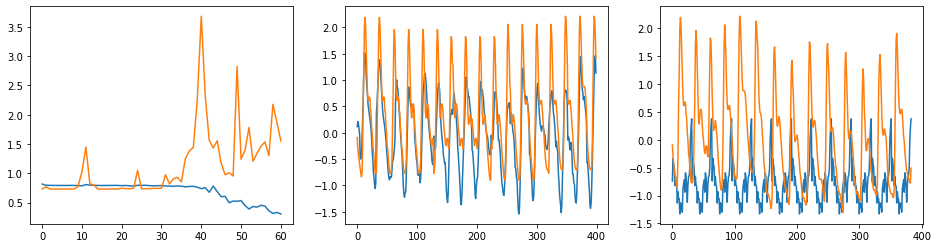

Epoch 54
-------------------------------
loss: 0.255496  [    0/  197]
loss: 0.191478  [   32/  197]
loss: 0.249258  [   64/  197]
loss: 0.210048  [   96/  197]
loss: 0.168351  [  128/  197]
loss: 0.406286  [  160/  197]
loss: 1.582823  [   30/  197]
Test loss: 1.396799 



/home/sim/anaconda3/envs/rppgtorch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



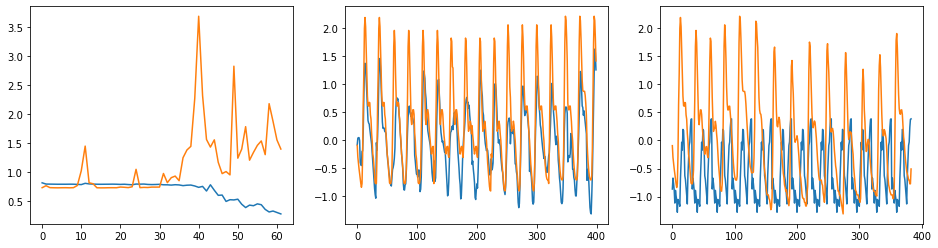

Epoch 55
-------------------------------
loss: 0.241432  [    0/  197]
loss: 0.195984  [   32/  197]
loss: 0.265413  [   64/  197]
loss: 0.237149  [   96/  197]
loss: 0.209638  [  128/  197]
loss: 0.430502  [  160/  197]
loss: 0.671292  [   30/  197]
Test loss: 1.651899 



/home/sim/anaconda3/envs/rppgtorch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



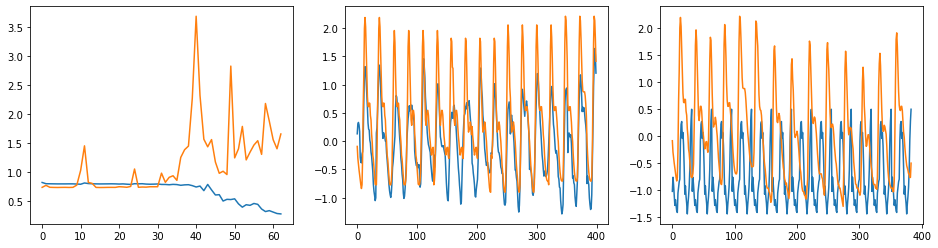

Epoch 56
-------------------------------
loss: 0.280901  [    0/  197]
loss: 0.176711  [   32/  197]
loss: 0.242216  [   64/  197]
loss: 0.253393  [   96/  197]
loss: 0.229083  [  128/  197]
loss: 0.387218  [  160/  197]
loss:     nan  [   30/  197]
Test loss:      nan 



/home/sim/anaconda3/envs/rppgtorch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



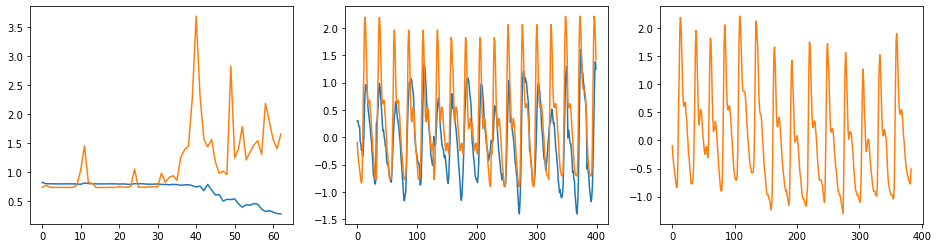

Epoch 57
-------------------------------
loss:     nan  [    0/  197]
loss:     nan  [   32/  197]
loss:     nan  [   64/  197]
loss:     nan  [   96/  197]
loss:     nan  [  128/  197]
loss:     nan  [  160/  197]
loss:     nan  [   30/  197]
Test loss:      nan 



/home/sim/anaconda3/envs/rppgtorch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



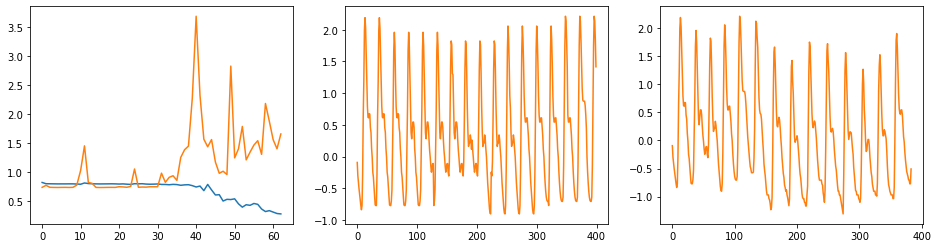

Epoch 58
-------------------------------
loss:     nan  [    0/  197]
loss:     nan  [   32/  197]
loss:     nan  [   64/  197]
loss:     nan  [   96/  197]
loss:     nan  [  128/  197]
loss:     nan  [  160/  197]
loss:     nan  [   30/  197]
Test loss:      nan 



/home/sim/anaconda3/envs/rppgtorch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



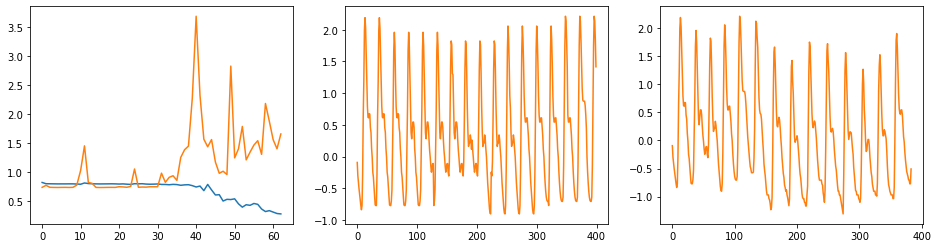

Epoch 59
-------------------------------
loss:     nan  [    0/  197]
loss:     nan  [   32/  197]
loss:     nan  [   64/  197]
loss:     nan  [   96/  197]
loss:     nan  [  128/  197]
loss:     nan  [  160/  197]
loss:     nan  [   30/  197]
Test loss:      nan 



/home/sim/anaconda3/envs/rppgtorch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



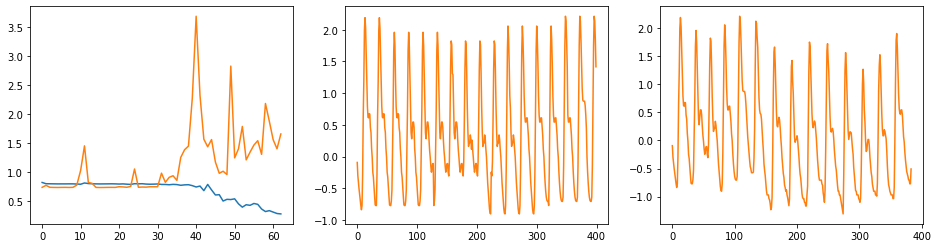

Epoch 60
-------------------------------
loss:     nan  [    0/  197]
loss:     nan  [   32/  197]
loss:     nan  [   64/  197]
loss:     nan  [   96/  197]
loss:     nan  [  128/  197]
loss:     nan  [  160/  197]
loss:     nan  [   30/  197]
Test loss:      nan 



/home/sim/anaconda3/envs/rppgtorch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



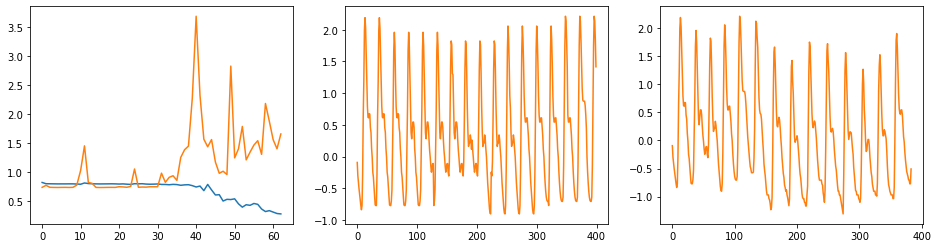

Epoch 61
-------------------------------
loss:     nan  [    0/  197]
loss:     nan  [   32/  197]
loss:     nan  [   64/  197]
loss:     nan  [   96/  197]
loss:     nan  [  128/  197]
loss:     nan  [  160/  197]
loss:     nan  [   30/  197]
Test loss:      nan 



/home/sim/anaconda3/envs/rppgtorch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



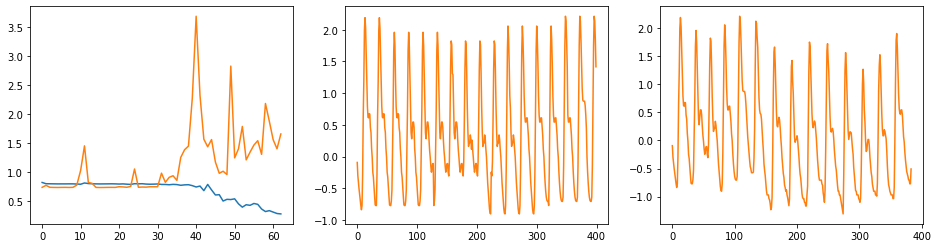

Epoch 62
-------------------------------
loss:     nan  [    0/  197]
loss:     nan  [   32/  197]
loss:     nan  [   64/  197]
loss:     nan  [   96/  197]
loss:     nan  [  128/  197]
loss:     nan  [  160/  197]
loss:     nan  [   30/  197]
Test loss:      nan 



/home/sim/anaconda3/envs/rppgtorch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



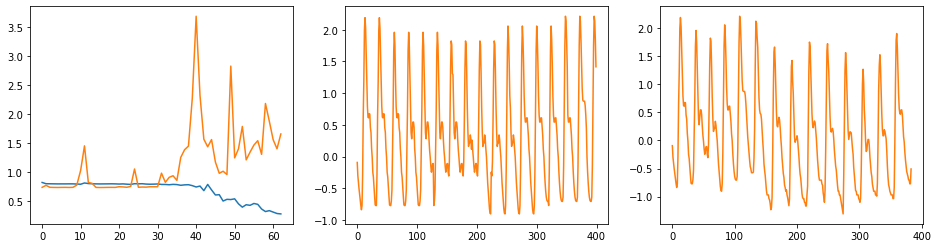

Epoch 63
-------------------------------
loss:     nan  [    0/  197]
loss:     nan  [   32/  197]
loss:     nan  [   64/  197]
loss:     nan  [   96/  197]
loss:     nan  [  128/  197]
loss:     nan  [  160/  197]
loss:     nan  [   30/  197]
Test loss:      nan 



/home/sim/anaconda3/envs/rppgtorch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



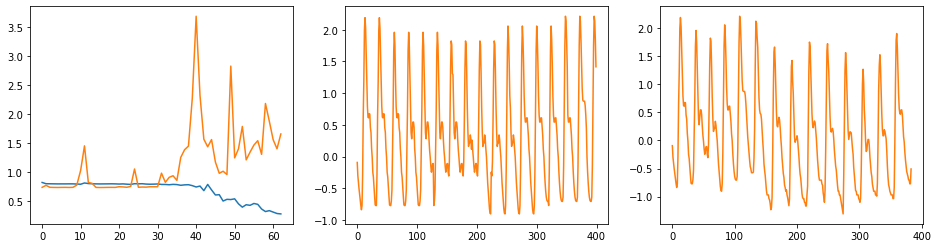

Epoch 64
-------------------------------
loss:     nan  [    0/  197]
loss:     nan  [   32/  197]
loss:     nan  [   64/  197]
loss:     nan  [   96/  197]
loss:     nan  [  128/  197]
loss:     nan  [  160/  197]
loss:     nan  [   30/  197]
Test loss:      nan 



/home/sim/anaconda3/envs/rppgtorch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



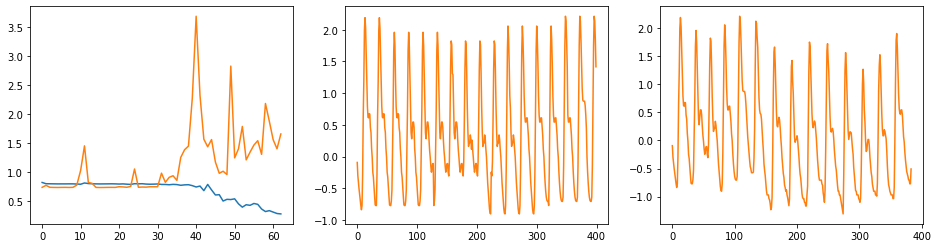

Epoch 65
-------------------------------
loss:     nan  [    0/  197]
loss:     nan  [   32/  197]
loss:     nan  [   64/  197]
loss:     nan  [   96/  197]
loss:     nan  [  128/  197]
loss:     nan  [  160/  197]
loss:     nan  [   30/  197]
Test loss:      nan 



/home/sim/anaconda3/envs/rppgtorch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



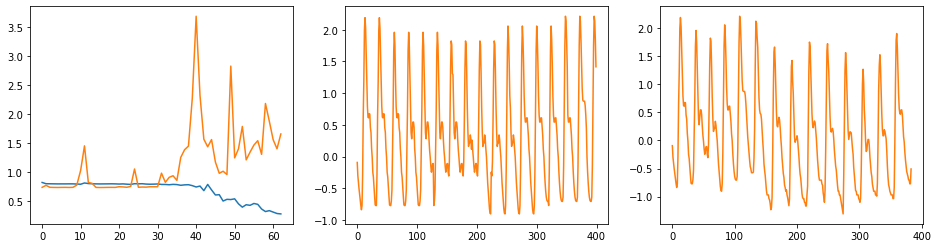

Epoch 66
-------------------------------
loss:     nan  [    0/  197]
loss:     nan  [   32/  197]
loss:     nan  [   64/  197]
loss:     nan  [   96/  197]
loss:     nan  [  128/  197]
loss:     nan  [  160/  197]
loss:     nan  [   30/  197]
Test loss:      nan 



/home/sim/anaconda3/envs/rppgtorch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



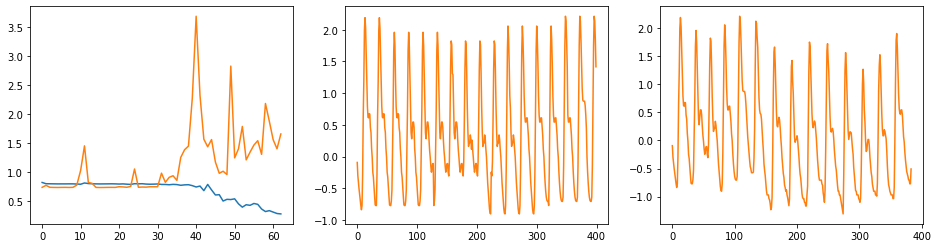

Epoch 67
-------------------------------
loss:     nan  [    0/  197]
loss:     nan  [   32/  197]
loss:     nan  [   64/  197]
loss:     nan  [   96/  197]
loss:     nan  [  128/  197]
loss:     nan  [  160/  197]
loss:     nan  [   30/  197]
Test loss:      nan 



/home/sim/anaconda3/envs/rppgtorch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



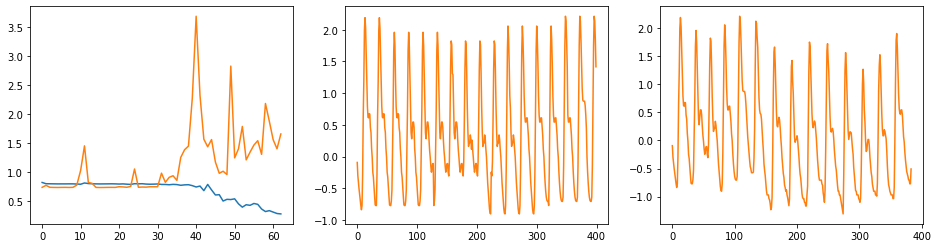

Epoch 68
-------------------------------
loss:     nan  [    0/  197]
loss:     nan  [   32/  197]
loss:     nan  [   64/  197]
loss:     nan  [   96/  197]
loss:     nan  [  128/  197]
loss:     nan  [  160/  197]
loss:     nan  [   30/  197]
Test loss:      nan 



/home/sim/anaconda3/envs/rppgtorch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



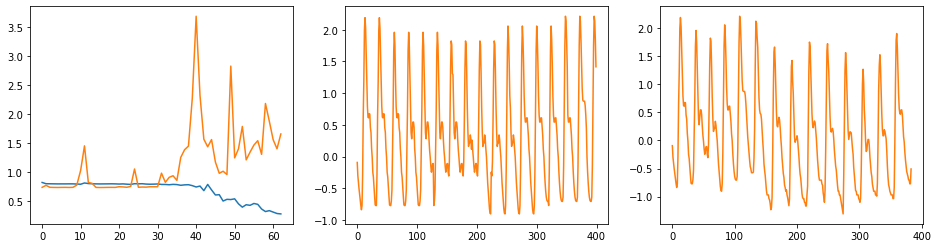

Epoch 69
-------------------------------
loss:     nan  [    0/  197]
loss:     nan  [   32/  197]
loss:     nan  [   64/  197]
loss:     nan  [   96/  197]
loss:     nan  [  128/  197]
loss:     nan  [  160/  197]
loss:     nan  [   30/  197]
Test loss:      nan 



/home/sim/anaconda3/envs/rppgtorch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



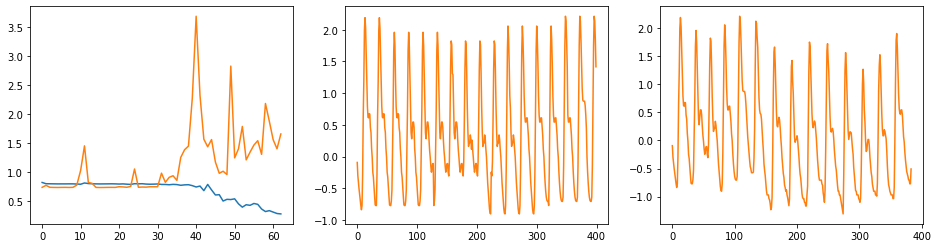

Epoch 70
-------------------------------
loss:     nan  [    0/  197]
loss:     nan  [   32/  197]
loss:     nan  [   64/  197]
loss:     nan  [   96/  197]
loss:     nan  [  128/  197]
loss:     nan  [  160/  197]
loss:     nan  [   30/  197]
Test loss:      nan 



/home/sim/anaconda3/envs/rppgtorch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



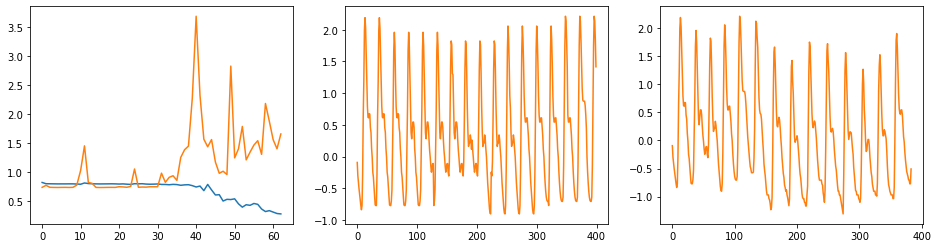

Epoch 71
-------------------------------
loss:     nan  [    0/  197]
loss:     nan  [   32/  197]
loss:     nan  [   64/  197]
loss:     nan  [   96/  197]
loss:     nan  [  128/  197]
loss:     nan  [  160/  197]
loss:     nan  [   30/  197]
Test loss:      nan 



/home/sim/anaconda3/envs/rppgtorch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



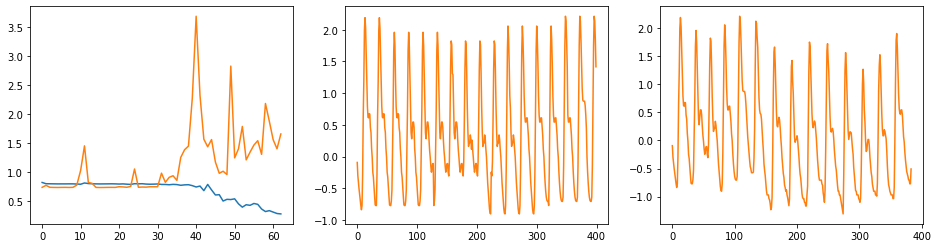

Epoch 72
-------------------------------
loss:     nan  [    0/  197]
loss:     nan  [   32/  197]
loss:     nan  [   64/  197]
loss:     nan  [   96/  197]
loss:     nan  [  128/  197]
loss:     nan  [  160/  197]
loss:     nan  [   30/  197]
Test loss:      nan 



/home/sim/anaconda3/envs/rppgtorch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



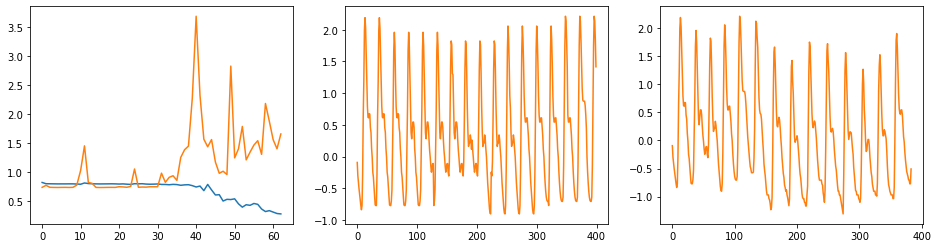

Epoch 73
-------------------------------
loss:     nan  [    0/  197]
loss:     nan  [   32/  197]
loss:     nan  [   64/  197]
loss:     nan  [   96/  197]
loss:     nan  [  128/  197]
loss:     nan  [  160/  197]
loss:     nan  [   30/  197]
Test loss:      nan 



/home/sim/anaconda3/envs/rppgtorch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



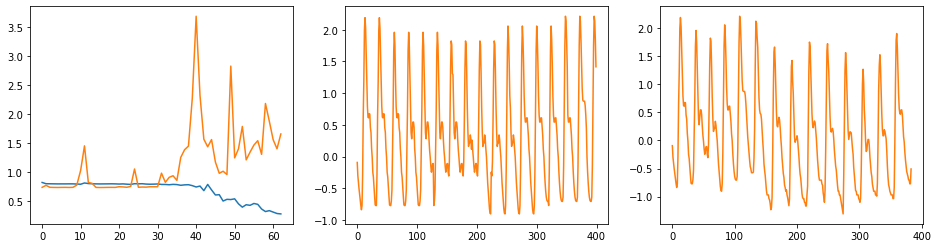

Epoch 74
-------------------------------
loss:     nan  [    0/  197]
loss:     nan  [   32/  197]
loss:     nan  [   64/  197]
loss:     nan  [   96/  197]
loss:     nan  [  128/  197]
loss:     nan  [  160/  197]
loss:     nan  [   30/  197]
Test loss:      nan 



/home/sim/anaconda3/envs/rppgtorch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



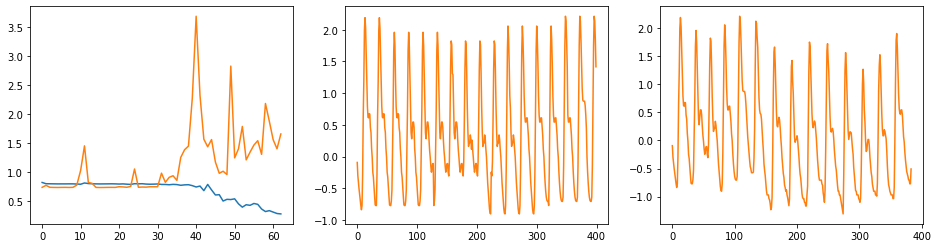

Epoch 75
-------------------------------
loss:     nan  [    0/  197]
loss:     nan  [   32/  197]
loss:     nan  [   64/  197]
loss:     nan  [   96/  197]
loss:     nan  [  128/  197]
loss:     nan  [  160/  197]
loss:     nan  [   30/  197]
Test loss:      nan 



/home/sim/anaconda3/envs/rppgtorch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



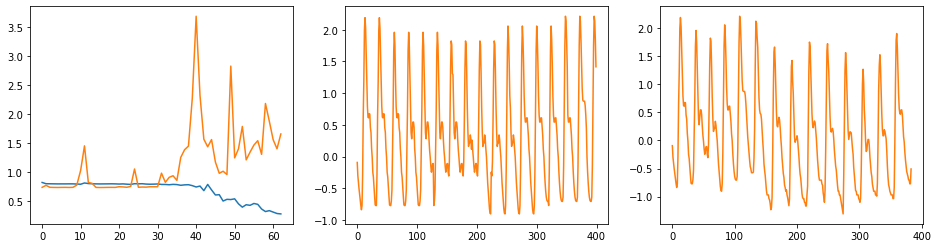

Epoch 76
-------------------------------
loss:     nan  [    0/  197]
loss:     nan  [   32/  197]
loss:     nan  [   64/  197]
loss:     nan  [   96/  197]
loss:     nan  [  128/  197]
loss:     nan  [  160/  197]
loss:     nan  [   30/  197]
Test loss:      nan 



/home/sim/anaconda3/envs/rppgtorch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



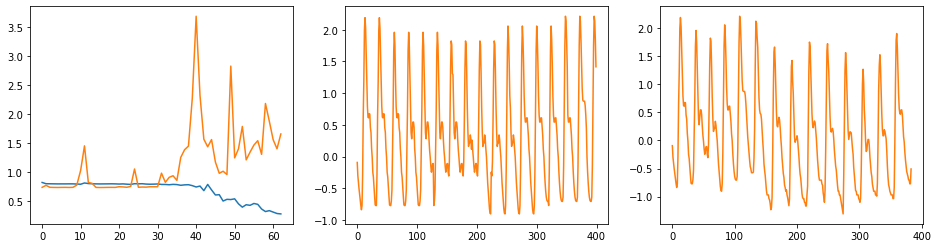

Epoch 77
-------------------------------
loss:     nan  [    0/  197]
loss:     nan  [   32/  197]
loss:     nan  [   64/  197]
loss:     nan  [   96/  197]
loss:     nan  [  128/  197]
loss:     nan  [  160/  197]
loss:     nan  [   30/  197]
Test loss:      nan 



/home/sim/anaconda3/envs/rppgtorch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



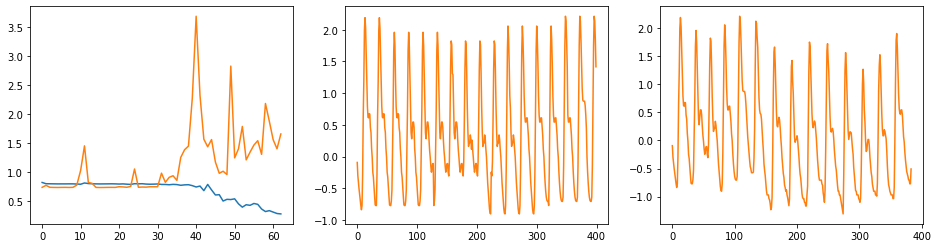

Epoch 78
-------------------------------
loss:     nan  [    0/  197]
loss:     nan  [   32/  197]
loss:     nan  [   64/  197]
loss:     nan  [   96/  197]
loss:     nan  [  128/  197]
loss:     nan  [  160/  197]
loss:     nan  [   30/  197]
Test loss:      nan 



/home/sim/anaconda3/envs/rppgtorch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



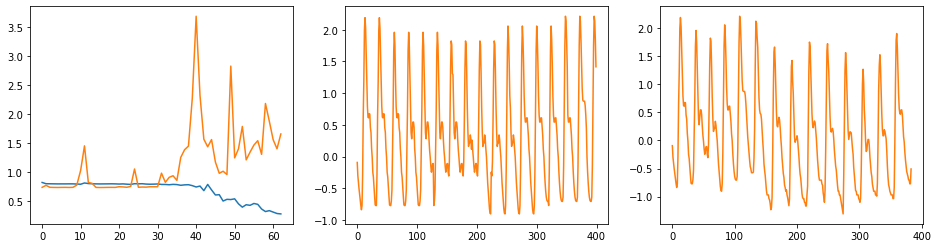

Epoch 79
-------------------------------
loss:     nan  [    0/  197]
loss:     nan  [   32/  197]
loss:     nan  [   64/  197]
loss:     nan  [   96/  197]
loss:     nan  [  128/  197]
loss:     nan  [  160/  197]
loss:     nan  [   30/  197]
Test loss:      nan 



/home/sim/anaconda3/envs/rppgtorch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



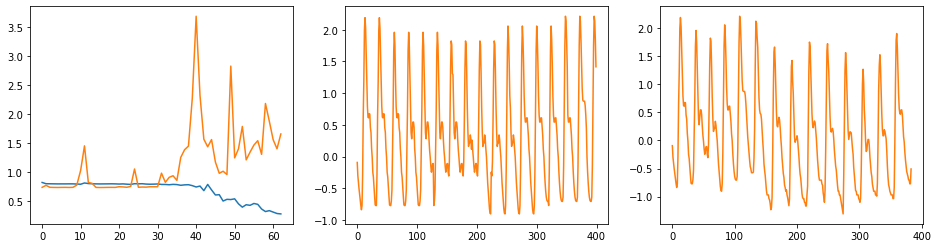

Epoch 80
-------------------------------
loss:     nan  [    0/  197]
loss:     nan  [   32/  197]
loss:     nan  [   64/  197]
loss:     nan  [   96/  197]
loss:     nan  [  128/  197]
loss:     nan  [  160/  197]
loss:     nan  [   30/  197]
Test loss:      nan 



/home/sim/anaconda3/envs/rppgtorch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



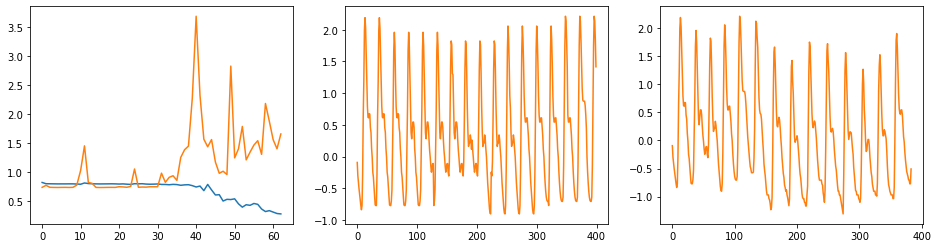

Epoch 81
-------------------------------
loss:     nan  [    0/  197]
loss:     nan  [   32/  197]
loss:     nan  [   64/  197]
loss:     nan  [   96/  197]
loss:     nan  [  128/  197]
loss:     nan  [  160/  197]
loss:     nan  [   30/  197]
Test loss:      nan 



/home/sim/anaconda3/envs/rppgtorch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



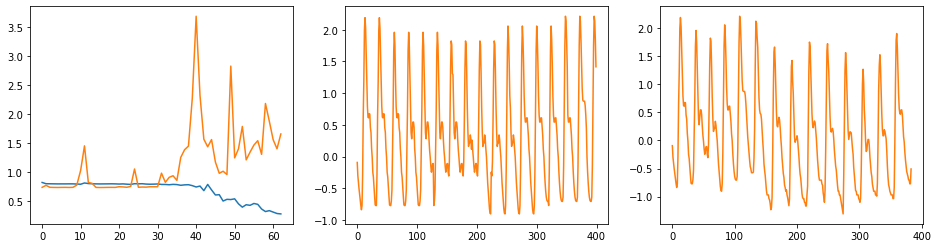

Epoch 82
-------------------------------
loss:     nan  [    0/  197]
loss:     nan  [   32/  197]
loss:     nan  [   64/  197]
loss:     nan  [   96/  197]
loss:     nan  [  128/  197]
loss:     nan  [  160/  197]
loss:     nan  [   30/  197]
Test loss:      nan 



/home/sim/anaconda3/envs/rppgtorch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



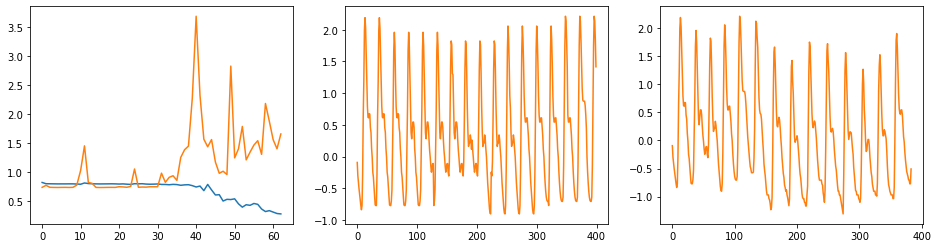

Epoch 83
-------------------------------
loss:     nan  [    0/  197]
loss:     nan  [   32/  197]
loss:     nan  [   64/  197]
loss:     nan  [   96/  197]
loss:     nan  [  128/  197]
loss:     nan  [  160/  197]
loss:     nan  [   30/  197]
Test loss:      nan 



/home/sim/anaconda3/envs/rppgtorch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



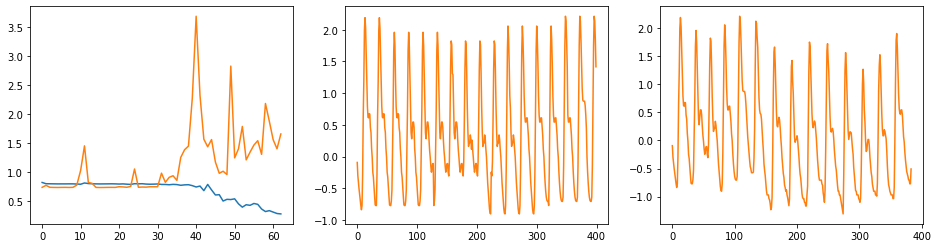

Epoch 84
-------------------------------
loss:     nan  [    0/  197]
loss:     nan  [   32/  197]
loss:     nan  [   64/  197]
loss:     nan  [   96/  197]
loss:     nan  [  128/  197]
loss:     nan  [  160/  197]
loss:     nan  [   30/  197]
Test loss:      nan 



/home/sim/anaconda3/envs/rppgtorch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



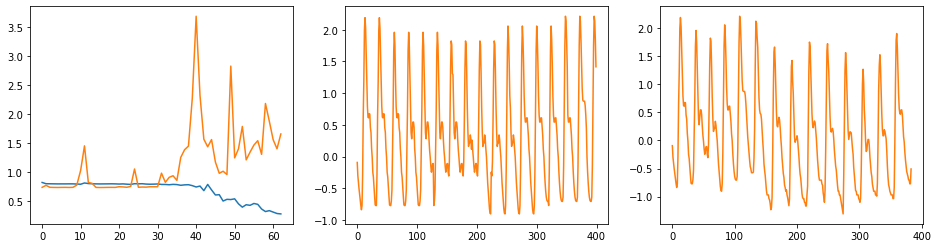

Epoch 85
-------------------------------
loss:     nan  [    0/  197]
loss:     nan  [   32/  197]
loss:     nan  [   64/  197]
loss:     nan  [   96/  197]
loss:     nan  [  128/  197]
loss:     nan  [  160/  197]
loss:     nan  [   30/  197]
Test loss:      nan 



/home/sim/anaconda3/envs/rppgtorch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



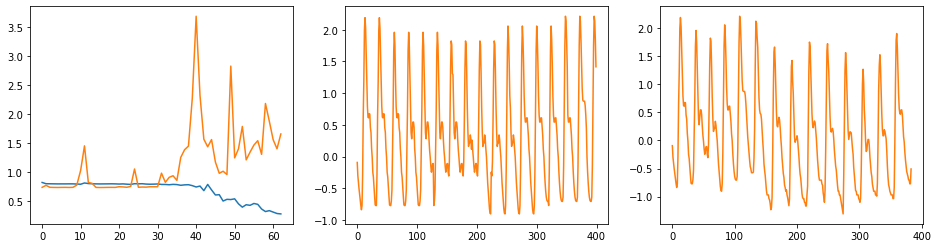

Epoch 86
-------------------------------
loss:     nan  [    0/  197]
loss:     nan  [   32/  197]
loss:     nan  [   64/  197]
loss:     nan  [   96/  197]
loss:     nan  [  128/  197]
loss:     nan  [  160/  197]
loss:     nan  [   30/  197]
Test loss:      nan 



/home/sim/anaconda3/envs/rppgtorch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



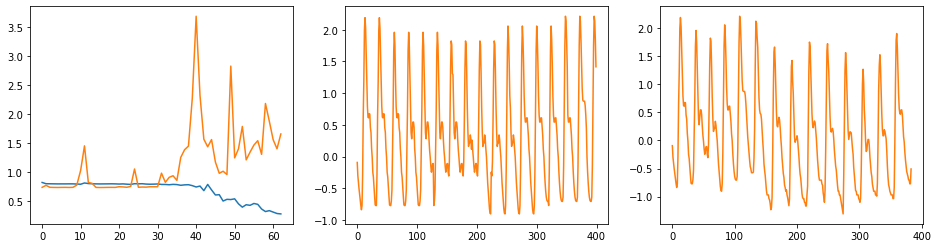

Epoch 87
-------------------------------
loss:     nan  [    0/  197]
loss:     nan  [   32/  197]
loss:     nan  [   64/  197]
loss:     nan  [   96/  197]
loss:     nan  [  128/  197]
loss:     nan  [  160/  197]
loss:     nan  [   30/  197]
Test loss:      nan 



/home/sim/anaconda3/envs/rppgtorch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



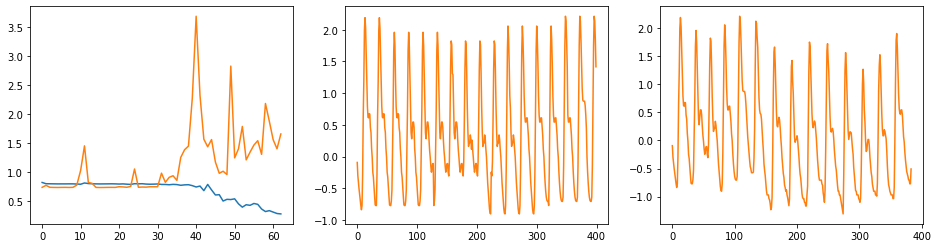

Epoch 88
-------------------------------
loss:     nan  [    0/  197]
loss:     nan  [   32/  197]
loss:     nan  [   64/  197]
loss:     nan  [   96/  197]
loss:     nan  [  128/  197]
loss:     nan  [  160/  197]
loss:     nan  [   30/  197]
Test loss:      nan 



/home/sim/anaconda3/envs/rppgtorch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



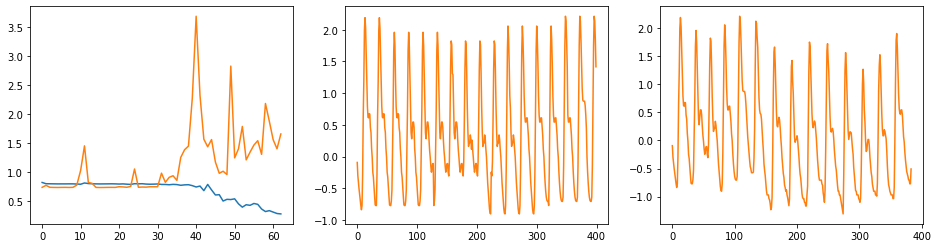

Epoch 89
-------------------------------
loss:     nan  [    0/  197]
loss:     nan  [   32/  197]
loss:     nan  [   64/  197]
loss:     nan  [   96/  197]
loss:     nan  [  128/  197]
loss:     nan  [  160/  197]
loss:     nan  [   30/  197]
Test loss:      nan 



/home/sim/anaconda3/envs/rppgtorch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



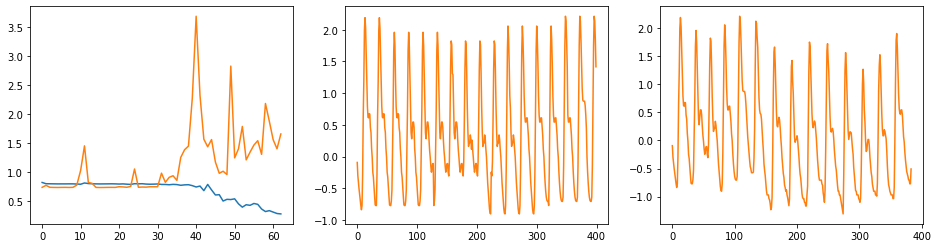

Epoch 90
-------------------------------
loss:     nan  [    0/  197]
loss:     nan  [   32/  197]
loss:     nan  [   64/  197]
loss:     nan  [   96/  197]
loss:     nan  [  128/  197]
loss:     nan  [  160/  197]
loss:     nan  [   30/  197]
Test loss:      nan 



/home/sim/anaconda3/envs/rppgtorch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



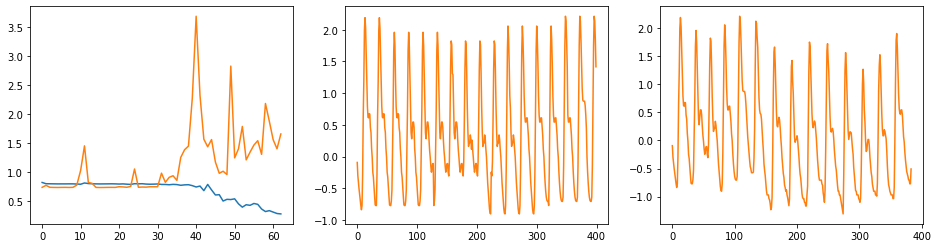

Epoch 91
-------------------------------
loss:     nan  [    0/  197]
loss:     nan  [   32/  197]
loss:     nan  [   64/  197]
loss:     nan  [   96/  197]
loss:     nan  [  128/  197]
loss:     nan  [  160/  197]
loss:     nan  [   30/  197]
Test loss:      nan 



/home/sim/anaconda3/envs/rppgtorch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



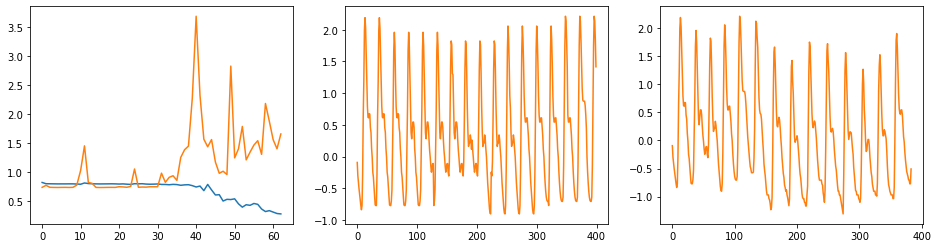

Epoch 92
-------------------------------
loss:     nan  [    0/  197]
loss:     nan  [   32/  197]
loss:     nan  [   64/  197]
loss:     nan  [   96/  197]
loss:     nan  [  128/  197]
loss:     nan  [  160/  197]
loss:     nan  [   30/  197]
Test loss:      nan 



/home/sim/anaconda3/envs/rppgtorch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



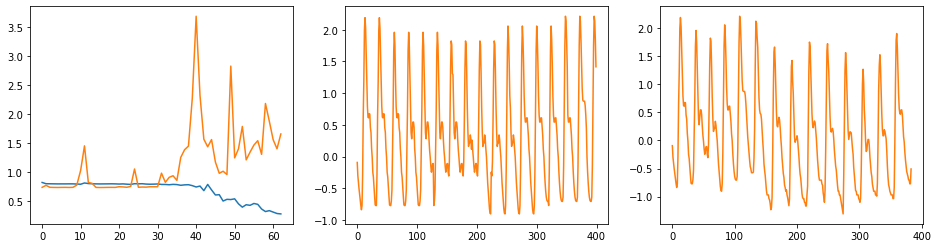

Epoch 93
-------------------------------
loss:     nan  [    0/  197]
loss:     nan  [   32/  197]
loss:     nan  [   64/  197]
loss:     nan  [   96/  197]
loss:     nan  [  128/  197]
loss:     nan  [  160/  197]
loss:     nan  [   30/  197]
Test loss:      nan 



/home/sim/anaconda3/envs/rppgtorch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



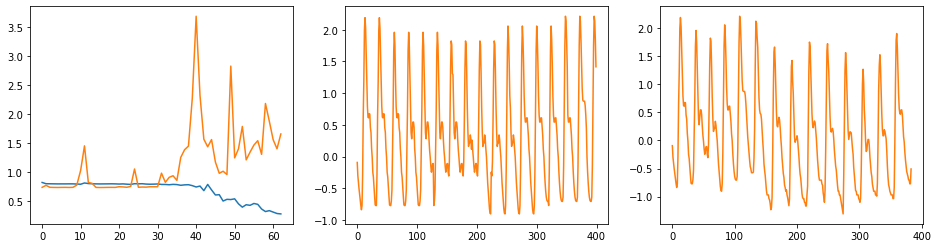

Epoch 94
-------------------------------
loss:     nan  [    0/  197]
loss:     nan  [   32/  197]
loss:     nan  [   64/  197]
loss:     nan  [   96/  197]
loss:     nan  [  128/  197]
loss:     nan  [  160/  197]
loss:     nan  [   30/  197]
Test loss:      nan 



/home/sim/anaconda3/envs/rppgtorch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



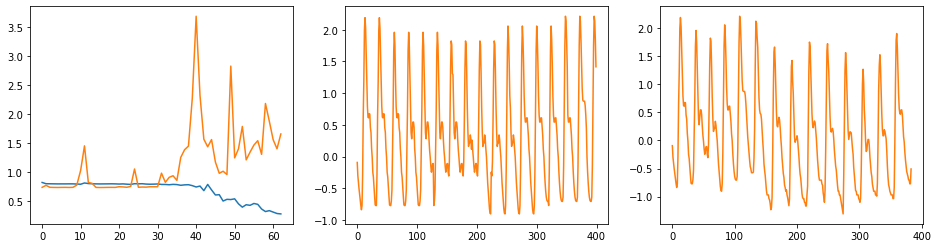

Epoch 95
-------------------------------
loss:     nan  [    0/  197]
loss:     nan  [   32/  197]
loss:     nan  [   64/  197]
loss:     nan  [   96/  197]
loss:     nan  [  128/  197]
loss:     nan  [  160/  197]
loss:     nan  [   30/  197]
Test loss:      nan 



/home/sim/anaconda3/envs/rppgtorch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



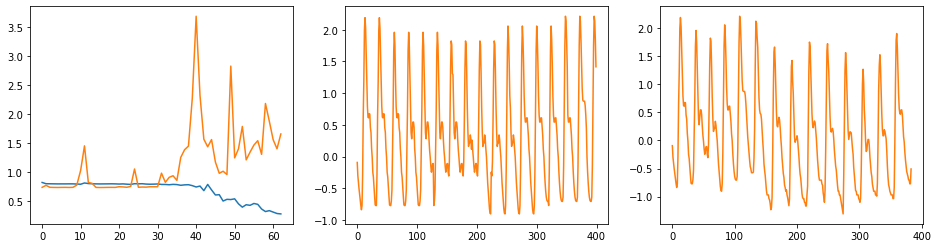

Epoch 96
-------------------------------
loss:     nan  [    0/  197]
loss:     nan  [   32/  197]
loss:     nan  [   64/  197]
loss:     nan  [   96/  197]
loss:     nan  [  128/  197]
loss:     nan  [  160/  197]
loss:     nan  [   30/  197]
Test loss:      nan 



/home/sim/anaconda3/envs/rppgtorch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



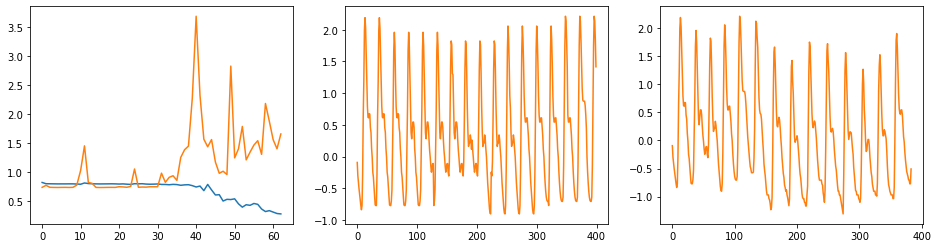

Epoch 97
-------------------------------
loss:     nan  [    0/  197]
loss:     nan  [   32/  197]
loss:     nan  [   64/  197]
loss:     nan  [   96/  197]
loss:     nan  [  128/  197]
loss:     nan  [  160/  197]
loss:     nan  [   30/  197]
Test loss:      nan 



/home/sim/anaconda3/envs/rppgtorch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



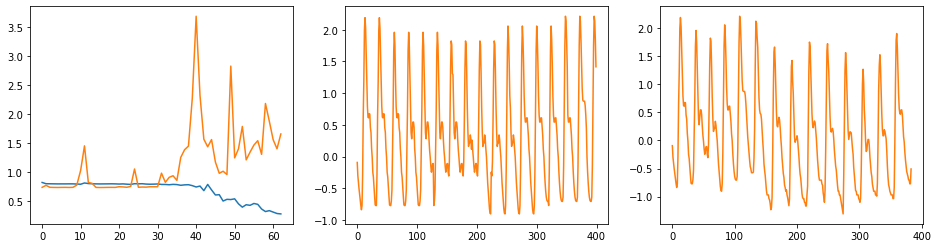

Epoch 98
-------------------------------
loss:     nan  [    0/  197]
loss:     nan  [   32/  197]
loss:     nan  [   64/  197]
loss:     nan  [   96/  197]
loss:     nan  [  128/  197]
loss:     nan  [  160/  197]
loss:     nan  [   30/  197]
Test loss:      nan 



/home/sim/anaconda3/envs/rppgtorch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



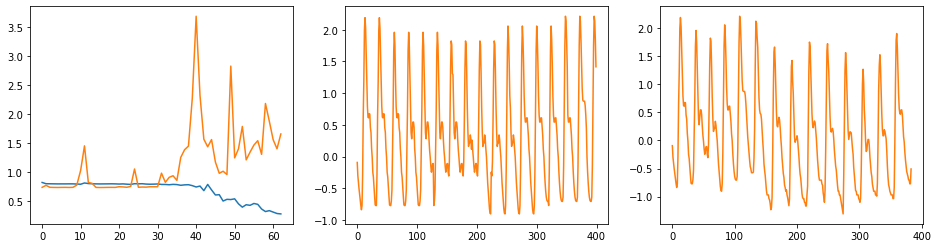

Epoch 99
-------------------------------
loss:     nan  [    0/  197]
loss:     nan  [   32/  197]
loss:     nan  [   64/  197]
loss:     nan  [   96/  197]
loss:     nan  [  128/  197]
loss:     nan  [  160/  197]
loss:     nan  [   30/  197]
Test loss:      nan 



/home/sim/anaconda3/envs/rppgtorch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



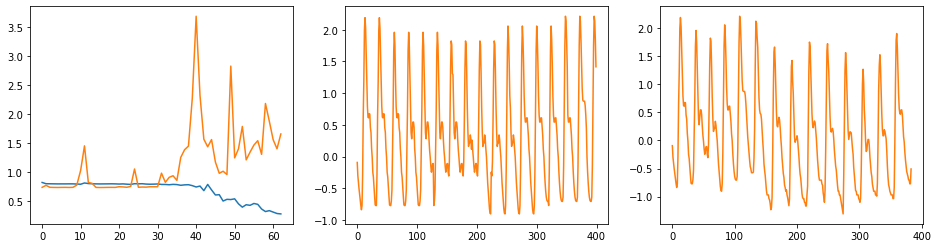

Epoch 100
-------------------------------
loss:     nan  [    0/  197]
loss:     nan  [   32/  197]
loss:     nan  [   64/  197]
loss:     nan  [   96/  197]
loss:     nan  [  128/  197]
loss:     nan  [  160/  197]
loss:     nan  [   30/  197]
Test loss:      nan 



/home/sim/anaconda3/envs/rppgtorch/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



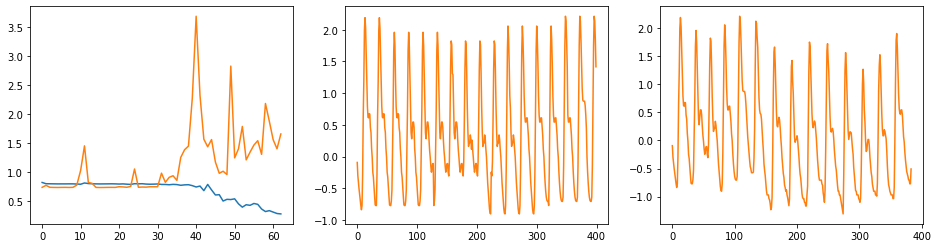

Done!


In [19]:
# 위 training code 결과